### To see this notebook with the folium maps, please use the following link: https://nbviewer.jupyter.org/github/pcanas/ada-project-oejp/blob/master/proj-notebook.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import geopandas as gpd # conda install geopandas
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point, Polygon
import folium # conda install -c conda-forge folium
import json
import pickle
import geopy
from geopy.extra.rate_limiter import RateLimiter
import re
import requests
import functools
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats import fisher_exact

### Import data
We import the dataset containing the food inspection. As the corpus size is reasonable, we will not need to use Spark for this project.

In [4]:
data = pd.read_csv('data/food-inspections.zip')

The "Historical Wards 2003-2015", "Zip Codes", "Community Areas", "Census Tracts" and "Wards" columns are all null.

In [5]:
for s in ["Historical Wards 2003-2015", "Zip Codes", "Community Areas", "Census Tracts", "Wards"]:
    print (data[data["Zip Codes"].isnull()].shape == data.shape)

True
True
True
True
True


Furthermore the columns 'City', 'State' are pointless as we only have data for Chicago,  
The same is true for the column "Location" because the same data is in the "Latitude" and "Longitude" columns.  

Therefore we decided on dropping all these columns.

In [6]:
data = data.drop(['AKA Name', 'City', 'State', "Historical Wards 2003-2015", "Zip Codes", "Community Areas", "Census Tracts", "Wards", "Location"], axis=1)
data.head()

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,Risk 1 (High),1025 W ADDISON ST,60613.0,2019-12-04T00:00:00.000,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381
1,2352734,CHILI'S T-I,34169.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666.0,2019-12-04T00:00:00.000,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428
2,2352713,NICK'S FIRE GRILL STEAK & LEMONADE INC.,2699090.0,NaN,Risk 1 (High),2900 W 63RD ST,60629.0,2019-12-04T00:00:00.000,License,Not Ready,NaN,41.779190,-87.695892
3,2352701,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,Risk 1 (High),3401 W BELMONT AVE,60618.0,2019-12-04T00:00:00.000,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546
4,2352727,PORTAGE PARK DAY NURSERY,2215815.0,Children's Services Facility,Risk 1 (High),5332-5334 W ADDISON ST,60641.0,2019-12-04T00:00:00.000,Canvass,Pass,NaN,41.946065,-87.760722


# Complete the dataset

According to [Kaggle's](https://www.kaggle.com/chicago/chicago-food-inspections) description: _"attempts have been made to minimize any and all duplicate inspection reports. However, the dataset may still contain such duplicates and the appropriate precautions should be exercised when viewing or analyzing these data"_.

Therefore, we have profoundly inspected the dataset in order to solve duplicate errors and other inconsistencies such as missing values. Besides, we have updated our dataset accordingly, in order to have a fully usable dataset.

## Duplicates


Entries must be identified by their Inspection ID. However, we can find some duplicated Inspection Ids with exactly the same report.

In [7]:
data[data.duplicated("Inspection ID", keep=False)].sort_values(by=["Inspection ID"]).head(6)

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
90011,1386194,McDONALD'S,1302136.0,Restaurant,Risk 2 (Medium),70 E GARFIELD BLVD,60615.0,2015-06-11T00:00:00.000,Short Form Complaint,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.794794,-87.622915
89989,1386194,McDONALD'S,1302136.0,Restaurant,Risk 2 (Medium),70 E GARFIELD BLVD,60615.0,2015-06-11T00:00:00.000,Short Form Complaint,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.794794,-87.622915
89995,1386195,THE NILE RESTAURANT,2334190.0,Restaurant,Risk 1 (High),1162 E 55TH ST,60615.0,2015-06-11T00:00:00.000,Complaint,Fail,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,41.795171,-87.597100
90064,1386195,THE NILE RESTAURANT,2334190.0,Restaurant,Risk 1 (High),1162 E 55TH ST,60615.0,2015-06-11T00:00:00.000,Complaint,Fail,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,41.795171,-87.597100
80043,1425177,ROCKY MOUNTAIN CHOCOLATE FACTORY,1926528.0,Restaurant,Risk 2 (Medium),11601 W TOUHY AVE,60666.0,2015-11-19T00:00:00.000,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,42.008536,-87.914428
79967,1425177,ROCKY MOUNTAIN CHOCOLATE FACTORY,1926528.0,Restaurant,Risk 2 (Medium),11601 W TOUHY AVE,60666.0,2015-11-19T00:00:00.000,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,42.008536,-87.914428


This duplicated rows can simply be removed.

In [8]:
print("Number of duplicate inspection IDs: " + str(len(data[data.duplicated("Inspection ID")])))
data = data.drop_duplicates()
print("Number of duplicate inspection IDs after removal: " + str(len(data[data.duplicated()])))

Number of duplicate inspection IDs: 149
Number of duplicate inspection IDs after removal: 0


## Deal with missing values

Let's first plot the number of missing values per feature

In [9]:
for col in data.columns:
    print("Number of null entries for " + col + ": " + str(len(data[data[col].apply(pd.isnull)])))
for col in data.columns:
    if isinstance(data[col][0], str):
        print("Number of empty string entries for " + col + ": " + str(len(data[data[col].apply(str).apply(str.isspace)])))

Number of null entries for Inspection ID: 0
Number of null entries for DBA Name: 0
Number of null entries for License #: 17
Number of null entries for Facility Type: 4768
Number of null entries for Risk: 69
Number of null entries for Address: 0
Number of null entries for Zip: 50
Number of null entries for Inspection Date: 0
Number of null entries for Inspection Type: 1
Number of null entries for Results: 0
Number of null entries for Violations: 52234
Number of null entries for Latitude: 689
Number of null entries for Longitude: 689
Number of empty string entries for DBA Name: 0
Number of empty string entries for Facility Type: 0
Number of empty string entries for Risk: 0
Number of empty string entries for Address: 3
Number of empty string entries for Inspection Date: 0
Number of empty string entries for Inspection Type: 0
Number of empty string entries for Results: 0
Number of empty string entries for Violations: 0


### Address
There are some addresses that are missing in that they only contain a few spaces.

In [10]:
data[data['Address'].apply(str.isspace)]

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
71474,1763245,EAT N RUN CHICKEN AND FISH,2442868.0,Restaurant,Risk 1 (High),,NaN,2016-04-19T00:00:00.000,License,Not Ready,NaN,NaN,NaN
191041,114452,Starfruit Cafe,2031651.0,NaN,Risk 2 (Medium),,60654.0,2010-05-05T00:00:00.000,License,Fail,NaN,NaN,NaN
192538,60405,CASA CENTRAL LA POSADA,0.0,Restaurant,Risk 1 (High),,NaN,2010-04-05T00:00:00.000,Canvass,Pass,37. TOILET ROOM DOORS SELF CLOSING: DRESSING R...,NaN,NaN


We will manually complete the addresses for the establishments that we can find:

In [11]:
data.loc[data["Inspection ID"]==1763245, "Address"] = "8233 S ASHLAND AVE"
data.loc[data["Inspection ID"]==60405, "Address"] = "3209 W EVERGREEN AVE"

In [12]:
data[data['Address'].apply(str.isspace)]

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
191041,114452,Starfruit Cafe,2031651.0,NaN,Risk 2 (Medium),,60654.0,2010-05-05T00:00:00.000,License,Fail,NaN,NaN,NaN


We will drop such row as it does not provide useful information

In [18]:
data.drop(191041, inplace=True)

### Latitude and longitude
There are entries that are missing coordinate data, which is needed to put them on the map.
We see that all entries have address data, so we try to fill in the null values for the coordinates by using Geopy that uses geocoders to get coordinates based on addresses. Through testing we found that using ArcGIS as a geocoder gives us a perfect result.

In [19]:
locator = geopy.geocoders.ArcGIS(user_agent='myGeocoder')
data_wo_latlong = data[data['Latitude'].apply(np.isnan)].groupby("DBA Name").first()
geocode = RateLimiter(locator.geocode, min_delay_seconds=2)
lats = pd.Series(index=data_wo_latlong.index)
longs = pd.Series(index=data_wo_latlong.index)
for name, address in list(zip(data_wo_latlong.index, data_wo_latlong['Address'])):
    if str.isspace(address):
        print('Empty address for ' + name + ' ignored')
        continue
    location = geocode(address + ", Chicago, United States")
    if location is not None:
        lats[name] = location.latitude
        longs[name] = location.longitude
    else:
        print('Did not find location for address: ' + address)

for name, lat, long in zip(lats.index, lats, longs):
    data['Latitude'] = np.where(data['DBA Name'] == name, lat, data['Latitude'])
    data['Longitude'] = np.where(data['DBA Name'] == name, long, data['Longitude'])

In [20]:
print("Number of entries without coordinate data: " + str(len(data[data["Latitude"].apply(pd.isnull)])))
data[data["Latitude"].apply(pd.isnull)]

Number of entries without coordinate data: 0


,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude


In [21]:
data.to_pickle("data/data.pkl")

In [37]:
data = None
data = pd.read_pickle("data/data.pkl")

### Fixing the Inspection Date
Here we will analyse and fix the dates column


In [38]:
data["Inspection Date"]

0         2019-12-04T00:00:00.000
1         2019-12-04T00:00:00.000
2         2019-12-04T00:00:00.000
3         2019-12-04T00:00:00.000
4         2019-12-04T00:00:00.000
                   ...           
196820    2010-01-04T00:00:00.000
196821    2010-01-04T00:00:00.000
196822    2010-01-04T00:00:00.000
196823    2010-01-04T00:00:00.000
196824    2010-01-04T00:00:00.000
Name: Inspection Date, Length: 196674, dtype: object

As seen above besides the dates the exact hours are also included but are set to 0. We will first remove them.

In [39]:
dates = data["Inspection Date"].apply(lambda s: s.split("T")[0])
dates.head(5)

0    2019-12-04
1    2019-12-04
2    2019-12-04
3    2019-12-04
4    2019-12-04
Name: Inspection Date, dtype: object

Next we convert it to pandas datetime.

In [40]:
data.loc[:,"Inspection Date"] = pd.to_datetime(dates, format = "%Y-%m-%d")

In [41]:
data.rename(columns={"Inspection Date": "Date"}, inplace =True)


In [42]:
data.head(1)

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,Risk 1 (High),1025 W ADDISON ST,60613.0,2019-12-04,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381


In [43]:
#data_year = data.copy()
#data_year.loc[] = 
inspections_per_year = data.rename(columns = {"Address":"Number of Inspections"}).groupby(data.Date.dt.year)["Number of Inspections"].count()
inspections_per_year

Date
2010    18066
2011    18748
2012    18866
2013    20951
2014    21540
2015    20876
2016    22794
2017    21568
2018    17140
2019    16125
Name: Number of Inspections, dtype: int64

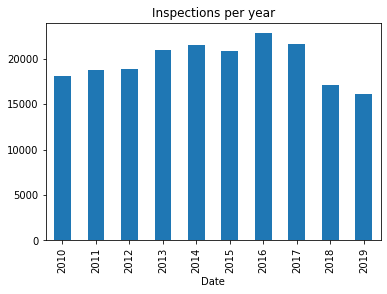

In [44]:
ax = inspections_per_year.plot.bar( )
_= ax.set_title("Inspections per year")

Note that the data for 2019 is incomplete, as we downloaded it in the last quarter of the year. 

In [45]:
data[data['Zip'].apply(pd.isnull)]

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Date,Inspection Type,Results,Violations,Latitude,Longitude
2570,2312774,CHICAGO COLLEGIATE CHARTER,3846104.0,School,Risk 1 (High),10909 S COTTAGE GROVE AVE,NaN,2019-09-24,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.696087,-87.608945
2795,2312540,CHICAGO COLLEGIATE CHARTER,3846104.0,School,Risk 1 (High),10909 S COTTAGE GROVE AVE,NaN,2019-09-19,Canvass Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.696087,-87.608945
20358,2222692,LEO'S FOOD AND LIQUOR,2535068.0,Liquor,Risk 3 (Low),4471 W LAWRENCE AVE,NaN,2018-09-21,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.967993,-87.740726
22630,2200428,LEO'S FOOD AND LIQUOR,2535068.0,Liquor,Risk 3 (Low),4471 W LAWRENCE AVE,NaN,2018-08-02,License,Not Ready,NaN,41.967993,-87.740726
32082,2135962,PERSPECTIVES CHARTER SCHOOL,2225546.0,School,Risk 1 (High),1930 S ARCHER AVE,NaN,2018-01-25,Canvass,Out of Business,NaN,41.856033,-87.628528
55732,1977089,SUBWAY,1991157.0,Restaurant,Risk 2 (Medium),2184 N CLYBOURN BLDG,NaN,2016-12-13,Canvass,Out of Business,NaN,41.780221,-87.644765
71474,1763245,EAT N RUN CHICKEN AND FISH,2442868.0,Restaurant,Risk 1 (High),8233 S ASHLAND AVE,NaN,2016-04-19,License,Not Ready,NaN,41.743891,-87.663242
86484,1566296,PARKWEST LIQUORS AND SMOKE SHOP,2354157.0,Liquor,Risk 3 (Low),2570 N LINCOLN AVE,NaN,2015-08-17,License Re-Inspection,Pass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.928597,-87.653388
86716,1562130,PARKWEST LIQUORS AND SMOKE SHOP,2354157.0,Liquor,Risk 3 (Low),2570 N LINCOLN AVE,NaN,2015-08-12,License,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...,41.928597,-87.653388
91596,1538026,FOSTER GROCERY AND DOLLAR PLUS,1992096.0,Grocery Store,Risk 3 (Low),3358 W FOSTER AVE,NaN,2015-05-14,Canvass,Out of Business,NaN,41.975801,-87.713499


### Zip
We supplement the zip codes by finding where the coordinates belong in a GeoJSON boundary map for zip codes.

In [46]:
data[data['Zip'].apply(pd.isnull)].sample(6)

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Date,Inspection Type,Results,Violations,Latitude,Longitude
194381,63277,SUN FOOD MART,2009479.0,Grocery Store,Risk 3 (Low),3601 W CERMAK RD,NaN,2010-02-24,Short Form Complaint,Pass,NaN,41.851553,-87.715059
177720,391371,GOLDEN HOUSE RESTAURANT,1443483.0,Restaurant,Risk 1 (High),4742-44 N RACINE AVE,NaN,2011-01-25,Canvass,Fail,24. DISH WASHING FACILITIES: PROPERLY DESIGNED...,41.968491,-87.659816
71474,1763245,EAT N RUN CHICKEN AND FISH,2442868.0,Restaurant,Risk 1 (High),8233 S ASHLAND AVE,NaN,2016-04-19,License,Not Ready,NaN,41.743891,-87.663242
166243,557522,S.G.A. COFFEE CAFE,18474.0,Restaurant,Risk 3 (Low),4300 N NARRAGANSETT,NaN,2011-08-30,Canvass,Pass,40. REFRIGERATION AND METAL STEM THERMOMETERS ...,41.958548,-87.786919
115570,1464217,DUNKIN DONUTS,1515116.0,Restaurant,Risk 2 (Medium),7545 N PAULINA ST,NaN,2014-04-02,Canvass,Out of Business,NaN,41.780221,-87.644765
157547,670661,DUNKIN DONUTS,1515116.0,Restaurant,Risk 2 (Medium),7545 N PAULINA ST,NaN,2012-02-21,Complaint,Pass w/ Conditions,"6. HANDS WASHED AND CLEANED, GOOD HYGIENIC PRA...",41.780221,-87.644765


In [47]:
map_zip = gpd.read_file('data/chicago_zip.geojson')
missing_zip = data[data['Zip'].apply(pd.isnull)].copy()
for index, lat, long in zip(missing_zip.index, missing_zip['Latitude'], missing_zip['Longitude']):
    for zip_code, mpoly in zip(map_zip.zip, map_zip.geometry): 
        for poly in mpoly:
            if poly.contains(Point(long,lat)): # Points in polygons have inverse lat, long
                missing_zip.at[index,'Zip'] = zip_code
data.update(missing_zip)

print("Number of entries without zip data: " + str(len(data[data['Zip'].apply(pd.isnull)])))
data[data['Zip'].apply(pd.isnull)]

Number of entries without zip data: 1


,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Date,Inspection Type,Results,Violations,Latitude,Longitude
125757,1106878.0,FILIPINO AMERICAN COUNCIL,2225427.0,Golden Diner,Risk 1 (High),1332 W DRIVING PARK ROAD BSMT,NaN,2013-09-26,Canvass,Out of Business,NaN,39.94981,-82.95809


A google map search of the address gave us the zip code 60187.

In [48]:
data.at[125757,"Zip"] = 60187.0

### License number
We have decided that license numbers are not important for our research. Therefore, we will delete the column.

In [49]:
data.drop(columns=['License #'], inplace=True)

### Facility Type
There are a lot of missing facility types.

In [50]:
null_facility = data[data['Facility Type'].apply(pd.isnull)]
null_facility

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Date,Inspection Type,Results,Violations,Latitude,Longitude
2,2352713.0,NICK'S FIRE GRILL STEAK & LEMONADE INC.,NaN,Risk 1 (High),2900 W 63RD ST,60629.0,2019-12-04,License,Not Ready,NaN,41.779190,-87.695892
11,2352613.0,SWEETGREEN,NaN,Risk 1 (High),900 W NORTH AVE,60614.0,2019-12-03,License,Not Ready,NaN,41.910982,-87.651209
20,2352633.0,THE SUNDAE STOP,NaN,All,931 W BELMONT AVE,60657.0,2019-12-03,License,Not Ready,NaN,41.939820,-87.652748
28,2352676.0,DREAMERS ACADEMY LLC,NaN,Risk 1 (High),1824 W GRAND AVE,60622.0,2019-12-03,License,Not Ready,NaN,41.890997,-87.673057
74,2352494.0,VICKY'S CAFE LLC,NaN,Risk 1 (High),1308 W 95TH ST,60643.0,2019-12-02,License,Not Ready,NaN,41.721413,-87.655782
...,...,...,...,...,...,...,...,...,...,...,...,...
196743,120276.0,BUTTER,NaN,Risk 3 (Low),130 S GREEN ST,60607.0,2010-01-06,Out of Business,Pass,NaN,41.879501,-87.648608
196754,160208.0,"LOVEBUGS, TODDLER PROGRAMS AND PRESCHOOL, LLC",NaN,Risk 1 (High),1327 N LARRABEE ST,60610.0,2010-01-05,Out of Business,Pass,NaN,41.905866,-87.643136
196765,74258.0,MAKIA FOOD,NaN,Risk 3 (Low),2458 S CALIFORNIA AVE,60608.0,2010-01-05,License Re-Inspection,Pass,NaN,41.846516,-87.695423
196805,70272.0,THE DOGHOUSE,NaN,Risk 1 (High),11601 W TOUHY AVE,60666.0,2010-01-05,Out of Business,Pass,NaN,42.008536,-87.914428


In [51]:
null_facility.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located      26
Fail                     365
No Entry                  68
Not Ready                 94
Out of Business         3921
Pass                     254
Pass w/ Conditions        39
Name: Count, dtype: int64

For the moment, we will not deal with these missing values, as obtaining the exact facility type is out of the scope and besides, most of the establishments are out of business.

### Risk

In [52]:
null_risk = data[data['Risk'].apply(pd.isnull)]
null_risk

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Date,Inspection Type,Results,Violations,Latitude,Longitude
1561,2316086.0,UNIVERSITY CENTER PROPERTY LLC,NaN,NaN,525 S STATE ST,60605.0,2019-10-18,License,Not Ready,NaN,41.875179,-87.627474
2438,2312988.0,COTTAGE GROVE FOOD LLC,NaN,NaN,8207 S COTTAGE GROVE,60619.0,2019-09-26,License,No Entry,NaN,41.745539,-87.604930
3484,2311745.0,MOJO 33 NORTH LASALLE LLC,Restaurant,NaN,33 N LA SALLE ST,60602.0,2019-09-04,License,Not Ready,NaN,41.882798,-87.632242
5458,2303724.0,HARBOR CHICAGO,NaN,NaN,1312 S WABASH AVE,60605.0,2019-07-25,License,Not Ready,NaN,41.865345,-87.625933
9855,2288271.0,TAVERN ON THE POINT,NaN,NaN,6722-26 N NORTHWEST HWY,60631.0,2019-05-06,License,Not Ready,NaN,42.003187,-87.817026
...,...,...,...,...,...,...,...,...,...,...,...,...
192365,150313.0,JO JO FOOD MART,NaN,NaN,3801 N CICERO AVE,60641.0,2010-04-07,Out of Business,Pass,NaN,41.949826,-87.747058
192780,58405.0,SOCIAL CLUB,NaN,NaN,1105 N CALIFORNIA AVE,60622.0,2010-03-29,Short Form Complaint,Pass,NaN,41.901286,-87.696692
193135,58385.0,SOCIAL CLUB,NaN,NaN,1105 N CALIFORNIA AVE,60622.0,2010-03-22,Short Form Complaint,Pass,NaN,41.901286,-87.696692
193851,58356.0,SOCIAL CLUB,NaN,NaN,1105 N CALIFORNIA AVE,60622.0,2010-03-08,Short Form Complaint,Pass,NaN,41.901286,-87.696692


In [53]:
null_risk.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located     8
Fail                    22
No Entry                 7
Not Ready               17
Out of Business          3
Pass                    12
Name: Count, dtype: int64

In [55]:
null_risk.groupby('Facility Type').count().rename(columns={"DBA Name": "Count"})["Count"]

Facility Type
AFTER SCHOOL PROGRAM     1
CHICAGO PARK DISTRICT    1
CHURCH                   1
FARMER'S MARKET          1
FOOD PANTRY/CHURCH       2
Illegal Vendor           1
Mobile Food Dispenser    1
RETAIL                   1
Restaurant               4
WAREHOUSE                1
unlicensed facility      2
Name: Count, dtype: int64

Same as before, for the moment we will not deal with missing values for Risk.

### Inspection Type

There is only one missing value for inspection type.

In [56]:
data[data['Inspection Type'].apply(pd.isnull)]

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Date,Inspection Type,Results,Violations,Latitude,Longitude
65723,1946612.0,ARAMARL-FRESHII,Restaurant,Risk 1 (High),2650 N CLARK ST,60614.0,2016-07-14,NaN,Pass,NaN,41.930833,-87.644135


We will further investigate this by plotting other inspections for the same establishment.

In [57]:
data[data['DBA Name'] == 'ARAMARL-FRESHII']

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Date,Inspection Type,Results,Violations,Latitude,Longitude
16586,2243562.0,ARAMARL-FRESHII,Restaurant,Risk 1 (High),2650 N CLARK ST,60614.0,2018-12-13,Canvass,Out of Business,NaN,41.930833,-87.644135
46410,2050815.0,ARAMARL-FRESHII,Restaurant,Risk 1 (High),2650 N CLARK ST,60614.0,2017-05-22,Canvass,Pass w/ Conditions,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.930833,-87.644135
65723,1946612.0,ARAMARL-FRESHII,Restaurant,Risk 1 (High),2650 N CLARK ST,60614.0,2016-07-14,NaN,Pass,NaN,41.930833,-87.644135
65948,1946383.0,ARAMARL-FRESHII,Restaurant,Risk 1 (High),2650 N CLARK ST,60614.0,2016-07-12,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.930833,-87.644135


As we can see, this establishment failed the inspection to obtain its license to operate, and 2 days later it passed an unknown inspection.

As the next inspections are doing the average inspection for a establishment (therefore, they had already obtained their license), and it is very uncommon to have a new inspection after 2 days, we can infere that such entry was done after solving the violations that made the license inspection fail. Therefore, the inspection type will be 'License'.

In [58]:
data.at[63843,"Inspection Type"] = "License"

### Violations
There are plenty of missing values for Violations.

In [59]:
null_violations = data[data['Violations'].apply(pd.isnull)]
null_violations

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Date,Inspection Type,Results,Violations,Latitude,Longitude
2,2352713.0,NICK'S FIRE GRILL STEAK & LEMONADE INC.,NaN,Risk 1 (High),2900 W 63RD ST,60629.0,2019-12-04,License,Not Ready,NaN,41.779190,-87.695892
4,2352727.0,PORTAGE PARK DAY NURSERY,Children's Services Facility,Risk 1 (High),5332-5334 W ADDISON ST,60641.0,2019-12-04,Canvass,Pass,NaN,41.946065,-87.760722
5,2352738.0,AMARIT RESTAURANT,Restaurant,Risk 1 (High),600 S DEARBORN ST,60605.0,2019-12-04,Canvass Re-Inspection,Pass,NaN,41.874481,-87.629357
6,2352684.0,CHIPOTLE MEXICAN GRILL,Restaurant,Risk 1 (High),1025 W ADDISON ST,60613.0,2019-12-04,License Re-Inspection,Pass w/ Conditions,NaN,41.947118,-87.655381
9,2352696.0,GATEWAY MONTESSORI SCHOOL,Children's Services Facility,Risk 1 (High),4041 N PULASKI RD,60641.0,2019-12-04,Canvass,Pass,NaN,41.954877,-87.727505
...,...,...,...,...,...,...,...,...,...,...,...,...
196818,67733.0,WOLCOTT'S,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,60613.0,2010-01-04,License Re-Inspection,Pass,NaN,41.961606,-87.675967
196819,67757.0,DUNKIN DONUTS/BASKIN-ROBBINS,Restaurant,Risk 2 (Medium),100 W RANDOLPH ST,60601.0,2010-01-04,Tag Removal,Pass,NaN,41.884586,-87.631010
196820,52234.0,Cafe 608,Restaurant,Risk 1 (High),608 W BARRY AVE,60657.0,2010-01-04,License Re-Inspection,Pass,NaN,41.938007,-87.644755
196822,67732.0,WOLCOTT'S,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,60613.0,2010-01-04,License Re-Inspection,Pass,NaN,41.961606,-87.675967


In [60]:
null_violations.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located       68
Fail                     3112
No Entry                 5889
Not Ready                1856
Out of Business         16880
Pass                    23964
Pass w/ Conditions        464
Name: Count, dtype: int64

We can see that most of these values are NaN because the results of the inspection reflect no violation.

In [61]:
data.loc[(data['Violations'].apply(pd.isnull) & (~data['Results'].str.contains("Fail") & ~data['Results'].str.contains("Pass w/ Conditions"))), "Violations"] = "No Violation"
data.loc[(data['Violations'].apply(pd.isnull) & (data['Results'].str.contains("Fail") | data['Results'].str.contains("Pass w/ Conditions"))), "Violations"] = "No Data"

In [62]:
data[data['Violations'].apply(pd.isnull)]

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Date,Inspection Type,Results,Violations,Latitude,Longitude


# Information about columns

Here, we try to get a better understanding of the dataset as a whole, and look at columns which contain diverse data.

## Facility Type
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

Type of facility: Each establishment is described by one of the following: bakery, banquet hall, candy store, caterer, coffee shop, day care center (for ages less than 2), day care center (for ages 2 – 6), day care center (combo, for ages less than 2 and 2 – 6 combined), gas station, Golden Diner, grocery store, hospital, long term care center(nursing home), liquor store, mobile food dispenser, restaurant, paleteria, school, shelter, tavern, social club, wholesaler, or Wrigley Field Rooftop. 

We created keywords for each type of facility. We also added ice cream, donut, and nan.

In [11]:
def format_string(s): 
    return re.sub(r'[^a-z0-9\s]+', '', str.lower(s))

In [12]:
def group_type_from_string(types, strings):
    group = types.apply(format_string).map(lambda x: functools.reduce(lambda acc,b: b if b in x else acc, strings, 'invalid'))
    return group

In [ ]:
facility_types = data['Facility Type'].apply(str)
facility_types_unique = facility_types.drop_duplicates().reset_index(drop=True)

valid_facility_strings = ['bakery', 'banquet hall', 'candy', 'caterer', 'coffee', 'daycare', 'donut','gas station', 'golden diner', 'grocery', 'hospital', 'ice cream', 'long term', 'liquor store', 'mobile food', 'restaurant', 'paleteria', 'school', 'shelter', 'tavern', 'social club', 'wholesaler', 'wrigley field rooftop', 'nan']
print('Valid facility types')
print(facility_types_unique[facility_types_unique.apply(format_string).map(lambda x: any([y in x for y in valid_facility_strings]))])
print('Invalid facility types')
print(facility_types_unique[facility_types_unique.apply(format_string).map(lambda x: not any([y in x for y in valid_facility_strings]))])

There are a lot of facility types which we cannot classify. We will classify these as 'invalid' for now.

In [9]:
facility_type_group = group_type_from_string(facility_types, valid_facility_strings)

In [ ]:
data['Facility Type Group'] = facility_type_group

Percentage of invalid facility types: 4.282721661226192%
Percentage of nan facility types: 2.4238079258061562%


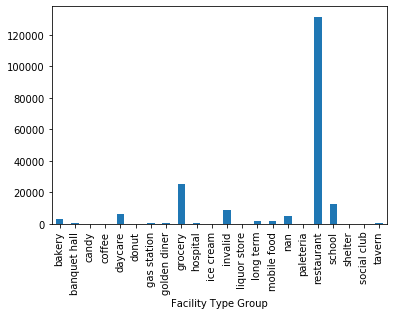

In [120]:
data.groupby('Facility Type Group').count()['DBA Name'].plot.bar()
print("Percentage of invalid facility types: " + str(len(data[data['Facility Type Group'] == 'invalid'])/len(data)*100) + "%")
print("Percentage of nan facility types: " + str(len(data[data['Facility Type Group'] == 'nan'])/len(data)*100) + "%")

We see here that 'restaurant' is the most common facility type. This is good, since we are concerned with restaurants for our research questions. The number of invalid/nan facility types is not too great, so we are satisfied with the result.

## Inspection types
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

Inspection type: An inspection can be one of the following types: 
* canvass, the most common type of inspection performed at a frequency relative to the risk of the establishment; 
* consultation, when the inspection is done at the request of the owner prior to the opening of the establishment; complaint, when  the inspection is done in response to a complaint against the establishment; 
* license, when the inspection is done as a requirement for the establishment to receive its license to operate; 
* suspect food poisoning, when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint-based inspection); 
* task-force inspection, when an inspection of a bar or tavern is done. 

Re-inspections can occur for most types of these inspections and are indicated as such.

In [14]:
inspection_types = data['Inspection Type'].drop_duplicates().reset_index(drop=True).apply(str)
valid_inspection_types = ['canvass', 'consultation', 'license', 'complaint', 'food poisoning', 'task', 're-inspection']
print(inspection_types[inspection_types.apply(format_string).map(lambda x: any([y in x for y in valid_inspection_types]))])
print(inspection_types[inspection_types.apply(format_string).map(lambda x: not any([y in x for y in valid_inspection_types]))])

0                         Canvass Re-Inspection
1                                       Canvass
2                       Complaint Re-Inspection
3                      Suspected Food Poisoning
4                                       License
5                                     Complaint
6                          Short Form Complaint
7                         License Re-Inspection
9                                  Consultation
10                               Complaint-Fire
11                 Complaint-Fire Re-inspection
12                           License-Task Force
13                       Task Force Liquor 1475
15                    Short Form Fire-Complaint
19       Suspected Food Poisoning Re-inspection
20                     Pre-License Consultation
22                    1315 license reinspection
30     finish complaint inspection from 5-18-10
36                  LIQOUR TASK FORCE NOT READY
37                         TASK FORCE NOT READY
40                                SFP/CO

We find that the classification for inspection types is hard. Several inspection types fit more than one group, such as LICENSE TASK FORCE / NOT -FOR-PROFIT CLUB, which could be classified as 'license' and 'task force'. Also, there are many inspection types that are deemed as invalid that could be manually annotated, for example TWO PEOPLE ATE AND GOT SICK could be classified as 'complaint'.

This data is not used right now, but it might be used later when trying to go more in depth. By then, we will refine the method to better accommodate for the difficulties in classification.

## Results
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

An inspection can pass, pass with conditions or fail. Establishments receiving a ‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15-29, respectively). Establishments receiving a ‘pass with conditions’ were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a ‘fail’ were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such. 

We add the categories 'not ready' and 'no entry', which covers all result types.

In [15]:
results = data['Results'].apply(str)
results_unique = data['Results'].drop_duplicates().reset_index(drop=True).apply(str)
valid_results_strings = ['pass','pass w/ conditions','fail','out of business', 'business not located', 'not ready', 'no entry']
print('Valid results')
print(results_unique[results_unique.apply(str.lower).map(lambda x: any([y == x for y in valid_results_strings]))])
print('Invalid results')
print(results_unique[results_unique.apply(str.lower).map(lambda x: not any([y == x for y in valid_results_strings]))])

Valid results
0      Pass w/ Conditions
1                    Pass
2                    Fail
3                No Entry
4         Out of Business
5               Not Ready
6    Business Not Located
Name: Results, dtype: object
Invalid results
Series([], Name: Results, dtype: object)


We see that the Results column is well-formed, and that we do not have to format it.

Text(0, 0.5, 'Count')

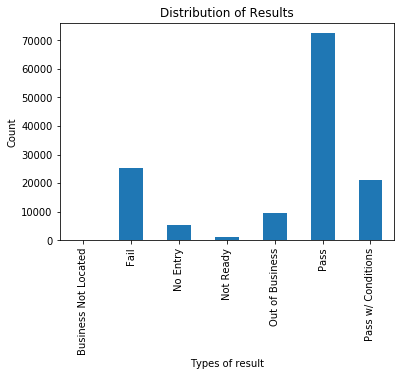

In [16]:
ax = data.groupby('Results').count()['DBA Name'].plot.bar(title="Distribution of Results")
ax.set_xlabel ("Types of result")
ax.set_ylabel ("Count")

## Violations
Violations are interesting in that they contain a lot of data which needs to be parsed to be usable. For example:

In [17]:
data['Violations'][102762]

'31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVICE ARTICLES PROPERLY STORED: NO REUSE OF SINGLE SERVICE ARTICLES - Comments: OBSERVED DISPOSABLE CONDIMENT CUPS BEING USED TO DISPENSE SAUCES IN THE COOK LINE COOLERS. MUST PROVIDE SCOOPS WITH HANDLES, THAT CAN BE PROPERLY WASHED, RINSED AND SANITIZED, TO DISPENSE FOOD. | 34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: MUST STORE ALL BEVERAGES IN WALK IN COOLER AND CHEMICAL BOTTLES NEAR ICE MACHINE AT LEAST 6 INCHES OFF THE FLOOR.'

Violations seem to have the structure:
(&lt;violation number>. &lt;violation title> - &lt;violation comments> - | )+ We create a regex to be able to extract the violation numbers, which can later be used. The other data is not considered at the moment.

According to https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF, critical violations are numbered 1-14, and serious violations are numbered 15-29. If these are found and fixed during the inspection, the inspection will pass with conditions. Otherwise it will fail.

In [18]:
re_num = re.compile(r'([0-9]+)\.\s.*?\s\|')
violation_numbers = data.set_index('Inspection ID').copy()['Violations'].apply(str).apply(re_num.findall).apply(lambda xs: list(map(lambda x: int(x), xs)))
critical_violations = range(1,14+1)
serious_violations = range(15, 29+1)
violation_numbers
# Maybe we can actually connect violation numbers to result "Out of business"
# See under "Under what conditions will a food establishment get shut down?" https://dchealth.dc.gov/service/understanding-food-establishment-inspections
# While this is for Washington DC, I think it could apply to us too
# Also see "Results" in https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF

Inspection ID
2321041.0                     [10, 10, 44, 49, 51, 53]
2320655.0         [36, 37, 39, 39, 41, 47, 47, 55, 55]
2315954.0     [36, 37, 39, 39, 41, 47, 47, 48, 55, 55]
2315816.0    [1, 2, 5, 10, 36, 37, 39, 49, 51, 57, 58]
2315792.0                       [3, 5, 10, 23, 39, 55]
                               ...                    
284340.0                                      [33, 34]
284356.0                      [18, 32, 33, 34, 36, 38]
278075.0                                          [34]
233495.0                                          [38]
67962.0                                       [32, 34]
Name: Violations, Length: 135023, dtype: object

We explode the violation numbers and plot the count of each.

In [19]:
def plot_violation_distribution(violation_numbers_series):
    violation_numbers_exploded = violation_numbers_series.explode().dropna().sort_values()
    violation_numbers_percentages = violation_numbers_exploded.groupby(violation_numbers_exploded).count()/len(violation_numbers_exploded)
    ax = violation_numbers_percentages.plot.bar(figsize=(20,5), title="Distribution of Violation types")
    ax.set_xlabel("Types of violation")
    ax.set_ylabel("Percentage")

/home/widmark/Anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:2897: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


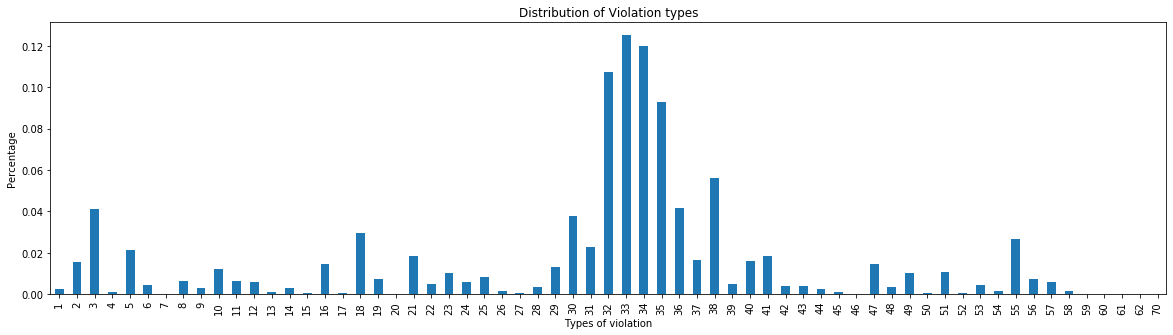

In [20]:
plot_violation_distribution(violation_numbers)

We then map the numbers to their severity.

In [21]:
violations_severity = violation_numbers.apply(lambda xs: list(map(lambda x: 'critical' if x in critical_violations else 'serious' if x in serious_violations else 'non-serious', xs)))
violations_severity = violations_severity.apply(lambda xs: ['no violation'] if len(xs) == 0 else xs)
violations_severity

Inspection ID
2321041.0    [critical, critical, non-serious, non-serious,...
2320655.0    [non-serious, non-serious, non-serious, non-se...
2315954.0    [non-serious, non-serious, non-serious, non-se...
2315816.0    [critical, critical, critical, critical, non-s...
2315792.0    [critical, critical, critical, serious, non-se...
                                   ...                        
284340.0                            [non-serious, non-serious]
284356.0     [serious, non-serious, non-serious, non-seriou...
278075.0                                         [non-serious]
233495.0                                         [non-serious]
67962.0                             [non-serious, non-serious]
Name: Violations, Length: 135023, dtype: object

We can now plot the counts for different severities.

Text(17.200000000000003, 0.5, 'Count')

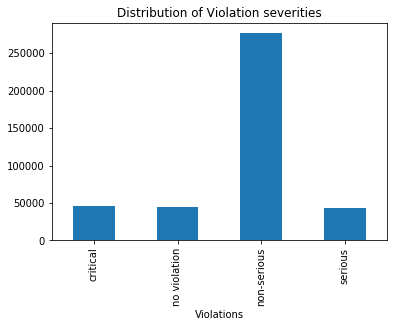

In [22]:
violations_severity_exploded = violations_severity.explode()
violations_severity_exploded.groupby(violations_severity_exploded).count().plot.bar(title="Distribution of Violation severities")
ax.set_xlabel ("Violation severity")
ax.set_ylabel ("Count")

We see that most violations are non-serious.

We will use this data later to analyse how parts of the data sets are missing.

# Supplementing the data

## Income by zip code
https://towardsdatascience.com/getting-census-data-in-5-easy-steps-a08eeb63995d

Attribution statement: This product uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

Zip code 60666 is the zip code for O'Hare International Airport.
Zip code 60627 is the zip code for Golden Gate Park.
These do not have a household median income since nobody lives there.

In [ ]:
incomes = []
income_by_zip_address = "https://api.census.gov/data/%s/acs/acs5?key=%s&get=%s&for=zip%%20code%%20tabulation%%20area:%s" 
year = "2017" # 2009-2017
api_key = "" # Request here: https://www.census.gov/developers/
income_variable = "B19013_001E"
zip_codes = data['Zip'].drop_duplicates()

for zip_code in zip_codes:
    if pd.isnull(zip_code):
        continue
        
    called_api = income_by_zip_address % (year, api_key, income_variable, int(zip_code))
    response = requests.get(called_api)
    if response.status_code == 200:
        formatted_response = json.loads(response.text)
        print(formatted_response)
        incomes.append(formatted_response)
    else:
        print('Could not find income for zip code: ' + str(int(zip_code)))
    # add to some list or something, also exception handling

In [ ]:
with open('data/income_data.pkl', 'wb') as f:
    pickle.dump(incomes, f)

In [23]:
with open('data/income_data.pkl', 'rb') as f:
    incomes = pickle.load(f)

In [24]:
print(incomes[0][1])

['63106', '60625']


In [25]:
zip_inc = [zi[1]for zi in incomes  ]
dict_inc = {"Income":[int(i[0]) for i in zip_inc], "Zip":[i[1] for i in zip_inc] }
econ_data = pd.DataFrame (dict_inc, columns = ["Income", "Zip"])

In [26]:
econ_data.sort_values("Income", ascending = False)

,Income,Zip
105,204118,60022
69,148462,60091
85,141268,60015
14,140114,60603
26,139179,60606
...,...,...
11,27617,60644
45,27573,60636
25,24941,60649
49,22467,60624


# Projecting information on a map

## Coordinates
We want to be able to visualize our dataset on a map based on coordinates. This is done by using Folium.

In [20]:
# Checking that none of the zip codes are null
data_names = data.reset_index().groupby('DBA Name').first()
nulls = data_names[data_names['Zip'].apply(pd.isnull)]
print(len(nulls))

0


Visualizing the first ten data points on the map of Chicago. 

In [21]:
middle_lat = data_names.Latitude.median()
middle_lon = data_names.Longitude.median()

In [ ]:
# Center of the map is the meadian Latitude and Longitude
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)
locations = folium.map.FeatureGroup()
#selecting the Latitude, Longitude and Names of the establishments
lats = data_names.Latitude
lons = data_names.Longitude
names = data_names.index

# Creating a marker for the first ten establishments
for lat, lon, name in list(zip(lats, lons, names))[0:10]:
    if np.isnan(lat) or np.isnan(lon):
        continue
    folium.Marker(
        location =  [lat, lon],
        tooltip = name,
        icon = folium.Icon(color='green', icon='info-sign')
    ).add_to(ch_map)
    
ch_map.add_child(locations)
ch_map

## Zip code areas
We use the zip code boundaries in a GeoJSON format from https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw. We then simply overlay them on the map.

In [ ]:
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)

data_zip = data.groupby('Zip').count().reset_index()[['Zip', 'Risk']].rename(columns={'Risk':'Count'})
data_zip['Zip'] = data_zip['Zip'].apply(int).apply(str)
map_zip = gpd.read_file('data/chicago_zip.geojson')
map_zip = map_zip.merge(data_zip, left_on='zip', right_on='Zip')
zip_geojson = folium.GeoJson(map_zip)

ch_choropleth = folium.Choropleth(
    geo_data=map_zip,
    name='choropleth',
    data=data_zip,
    columns=['Zip', 'Count'],
    key_on='feature.properties.zip',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Number of inspections per Zip',
)

folium.GeoJsonTooltip(["Count"]).add_to(ch_choropleth.geojson)

ch_choropleth.add_to(ch_map)

#folium.LayerControl().add_to(ch_map)
ch_map

In [12]:
ch_map.save('#Inspections.html')

In [ ]:
def format_string(s): 
    return re.sub(r'[^a-z0-9ì]+', '', str.lower(s)) # ì is for the chain Così

In [ ]:
def group_type_from_string(types, strings):
    group = types.apply(format_string).map(lambda x: functools.reduce(lambda acc,b: b if x.startswith(b) else acc, strings, 'invalid'))
    return group

# Find relevant rows in the dataset
We are interested in just the restaurants. However, there are some chains which are classified as both restaurants and another facility type. For example, McDonalds is classified as both restaurant and nan.

In [127]:
data[data['DBA Name'].apply(format_string) == 'mcdonalds'].groupby('Facility Type Group').count()

,Inspection ID,DBA Name,Facility Type,Risk,Address,Zip,Date,Inspection Type,Results,Violations,Latitude,Longitude
Facility Type Group,,,,,,,,,,,,
nan,20,20,0,20,20,20,20,20,20,20,20,20
restaurant,1366,1366,1366,1366,1366,1366,1366,1366,1366,1366,1366,1366


We want to keep data loss to a minimum, therefore we decide to classify bakery, banquet hall, candy, coffee, donut, golden diner, ice cream, mobile food, nan, paleteria and tavern as restaurants, as we assume that these facility types can serve food, and could be counted as restaurants by an inspector. Note that nan is kind of a catch-all, and that things that are not restaurants may be included. 

In [128]:
restaurant_equiv = ['restaurant', 'bakery', 'banquet hall', 'candy', 'coffee', 'donut', 'golden diner', 'ice cream', 'mobile food', 'nan', 'paleteria', 'tavern']
facility_type_group2 = group_type_from_string(facility_type_group, restaurant_equiv)
data.loc[:,'Facility Type Group'] = facility_type_group2
data = data[data['Facility Type Group'] != 'invalid']
data

,Inspection ID,DBA Name,Facility Type,Risk,Address,Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group
Zip,,,,,,,,,,,,
60601,2352647.0,THE HALAL GUYS,Restaurant,Risk 1 (High),180 N WABASH AVE,2019-12-03,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.885354,-87.626413,restaurant
60601,2352581.0,THE HALAL GUYS,Restaurant,Risk 1 (High),180 N WABASH AVE,2019-12-02,License,Not Ready,No Violation,41.885354,-87.626413,restaurant
60601,2321041.0,THE FAIRMONT CHICAGO/MILLENIUM ROOM,Restaurant,Risk 1 (High),200 N COLUMBUS DR,2019-11-05,Canvass Re-Inspection,Pass w/ Conditions,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.886006,-87.620829,restaurant
60601,2320655.0,MARKET THYME,Restaurant,Risk 1 (High),200 E RANDOLPH ST,2019-10-29,Canvass Re-Inspection,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.884632,-87.622248,restaurant
60601,2320659.0,MCDONALDï¿½S 25088,Restaurant,Risk 2 (Medium),233 N MICHIGAN AVE,2019-10-29,License Re-Inspection,Pass,No Violation,41.886567,-87.624385,restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
60827,1154772.0,GARDEN FAST FOOD,Restaurant,Risk 2 (Medium),13130 S ELLIS AVE,2012-12-19,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.656569,-87.597395,restaurant
60827,1154688.0,Sir Chicken,Restaurant,Risk 2 (Medium),13703 S Indiana BLDG,2012-11-09,Canvass,Out of Business,No Violation,41.646554,-87.617083,restaurant
60827,1154687.0,THE NEW STORE MART INC.,Restaurant,Risk 1 (High),13543 S INDIANA AVE,2012-11-09,Canvass,No Entry,No Violation,41.648818,-87.617080,restaurant


## Categorizing the data
We use the list of US restaurant chains found here: https://en.wikipedia.org/wiki/List_of_restaurant_chains_in_the_United_States, which we convert to CSV using the tool here: https://wikitable2csv.ggor.de/.

In [129]:
restaurant_chains = pd.read_csv('data/restaurant_chains.csv')
restaurant_chains

,Name,Original location,Year started,Head office location,Number of worldwide locations,Areas served,Notes
0,Jollibee,"Quezon City, Philippines",1978,"Quezon City, Philippines","1,200","West, Mid-Atlantic, Hawaii",NaN
1,L&L Hawaiian Barbecue,"Honolulu, Hawaii",1976,"Honolulu, Hawaii",200+,"West, Southeast, New York, Hawaii, Alaska",NaN
2,Manchu Wok,"Peterborough, Ontario, Canada",1980,"Markham, Ontario, Canada",101,Nationwide,NaN
3,Noodles & Company,"Denver, Colorado",1995,"Broomfield, Colorado",460,Nationwide,NaN
4,Panda Express,"Glendale, California",1983,"Rosemead, California","2,000+",Nationwide,NaN
...,...,...,...,...,...,...,...
388,Sizzler,"Culver City, California",1958,"Mission Viejo, California",270,NaN,NaN
389,Western Sizzlin',"Augusta, Georgia",1962,"Roanoke, Virginia",54,NaN,NaN
390,Chuck E. Cheese's,"San Jose, California",1977,"Irving, Texas",608,Nationwide,NaN
391,Dave & Busters,"Dallas, Texas",1982,"Dallas, Texas",134,Nationwide,NaN


In [132]:
#restaurant_chains['Name'] = restaurant_chains['Name'].apply(lambda a: str(a))
restaurant_chains_names = restaurant_chains['Name'].apply(format_string)
data_w_chain = data_chicago.copy()
data_w_chain['Chain'] = group_type_from_string(data_w_chain['DBA Name'], restaurant_chains_names)

For the restaurant chains, we assume a match with 'nan' as facility type group corresponds to a restaurant.

In [133]:
data_chains = data_w_chain[data_w_chain['Chain'] != 'invalid']
data_chains

,Inspection ID,DBA Name,Facility Type,Risk,Address,Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group,Chain
Zip,,,,,,,,,,,,,
60601,2352647.0,THE HALAL GUYS,Restaurant,Risk 1 (High),180 N WABASH AVE,2019-12-03,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.885354,-87.626413,restaurant,thehalalguys
60601,2352581.0,THE HALAL GUYS,Restaurant,Risk 1 (High),180 N WABASH AVE,2019-12-02,License,Not Ready,No Violation,41.885354,-87.626413,restaurant,thehalalguys
60601,2320659.0,MCDONALDï¿½S 25088,Restaurant,Risk 2 (Medium),233 N MICHIGAN AVE,2019-10-29,License Re-Inspection,Pass,No Violation,41.886567,-87.624385,restaurant,mcdonalds
60601,2312808.0,MCCORMICK & SCHMICK'S SEAFOOD RESTAURANT,Restaurant,Risk 1 (High),1 E WACKER DR,2019-09-24,Complaint Re-Inspection,Pass,"44. UTENSILS, EQUIPMENT & LINENS: PROPERLY STO...",41.886708,-87.627883,restaurant,mccormickschmicks
60601,2312784.0,SUBWAY #51581,Restaurant,Risk 1 (High),29 W LAKE ST,2019-09-24,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.885639,-87.629050,restaurant,subway
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60707,284340.0,TACO BELL,Restaurant,Risk 1 (High),6622 W FULLERTON AVE,2010-08-13,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.923739,-87.791349,restaurant,tacobell
60707,284356.0,APPLEBEE'S NEIGHBORHOOD GRILL,Restaurant,Risk 1 (High),6656 W GRAND AVE,2010-08-13,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.923728,-87.792777,restaurant,applebees
60707,278075.0,DOMINO'S PASTRIES,Bakery,Risk 1 (High),1745 N HARLEM AVE,2010-08-06,Canvass,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.912047,-87.805727,bakery,dominos


We have a problem with chain names like "Jack's" and "Roy's", since these are actual names, which can match with longer small business names. For example, "JACK'S FISH CHICKEN & MORE" is classified as "Jack's" for containing the name, but it has no association with the franchise "Jack's". 

Is it a big problem though? We analyse this by finding the percentage of problematic names in the set. The problematic names are handpicked from the top fifty most numerous restaurants. We assume collisions can be found for: chilis, jacks and roys.

In [134]:
data_chains.groupby('Chain').count()['DBA Name'].sort_values(ascending=False).head(n=50)

Chain
subway                     4017
dunkindonuts               2204
mcdonalds                  2191
starbucks                  1384
burgerking                  748
popeyes                     660
jimmyjohns                  615
chipotlemexicangrill        455
wendys                      452
churchschicken              306
tacobell                    295
dominos                     289
pizzahut                    280
aubonpain                   256
cornerbakerycafe            242
pandaexpress                232
whitecastle                 230
wingstop                    206
kfc                         196
argotea                     195
panerabread                 180
papajohnspizza              158
einsteinbrosbagels          141
jambajuice                  132
pretamanger                 121
quiznos                     105
chilis                      104
ihop                        102
qdoba                       101
sbarro                      100
noodlescompany               98
ca

In [135]:
problems = ['jacks', 'roys', 'chilis']
len(data_chains[data_chains['Chain'].map(lambda x: x in problems)])/len(data_chains)

0.011978542784229988

We are aware that our current chain identification procedure has flaws, but problematic names only constitutes to one percent of the whole dataset of chains. We therefore decide to ignore it.

For small businesses, we pick all the rows that has not been classified as a chain. Here, we do _not_ assume the 'nan' as the facility group type corresponds to a restaurant, and therefore we leave them out.

In [136]:
data_small_business = data_w_chain[data_w_chain['Chain'] == 'invalid']
data_small_business = data_small_business[data_small_business['Facility Type Group'] != 'nan']

We then concatenate the two datasets, finalizing the preprocessing part.

In [146]:
data = data_small_business.append(data_chains)

In [147]:
with open('data/data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
with open('data/final_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data

,Inspection ID,DBA Name,Facility Type,Risk,Address,Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group,Chain
Zip,,,,,,,,,,,,,
60601,2321041.0,THE FAIRMONT CHICAGO/MILLENIUM ROOM,Restaurant,Risk 1 (High),200 N COLUMBUS DR,2019-11-05,Canvass Re-Inspection,Pass w/ Conditions,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.886006,-87.620829,restaurant,invalid
60601,2320655.0,MARKET THYME,Restaurant,Risk 1 (High),200 E RANDOLPH ST,2019-10-29,Canvass Re-Inspection,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.884632,-87.622248,restaurant,invalid
60601,2315954.0,MARKET THYME,Restaurant,Risk 1 (High),200 E RANDOLPH ST,2019-10-16,Canvass Re-Inspection,Fail,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.884632,-87.622248,restaurant,invalid
60601,2315816.0,HALSTED STREET DELI,Restaurant,Risk 1 (High),222 N LA SALLE ST,2019-10-11,Canvass Re-Inspection,Pass w/ Conditions,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.886352,-87.632614,restaurant,invalid
60601,2315792.0,LAKESHORE SPORT & FITNESS,Restaurant,Risk 1 (High),211 N STETSON AVE,2019-10-11,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.886027,-87.622166,restaurant,invalid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60707,284340.0,TACO BELL,Restaurant,Risk 1 (High),6622 W FULLERTON AVE,2010-08-13,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.923739,-87.791349,restaurant,tacobell
60707,284356.0,APPLEBEE'S NEIGHBORHOOD GRILL,Restaurant,Risk 1 (High),6656 W GRAND AVE,2010-08-13,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.923728,-87.792777,restaurant,applebees
60707,278075.0,DOMINO'S PASTRIES,Bakery,Risk 1 (High),1745 N HARLEM AVE,2010-08-06,Canvass,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.912047,-87.805727,bakery,dominos


# Research Q1: Connection between economic prosperity and food safety and types of violations

Note: This question was done with the data loaded after having removed all non restaurant establishments in Q2. This was done to better compare Q1 and Q2. Also the code for creating the maps is contianed in the notebook with "eric" in the name.

There are some zip codes in our data that are outside the city of chicago. For question one we focus only on zip codes in the city of Chicago. These are provided in the GeoJSON data for Chicago.

In [ ]:
map_zip = gpd.read_file('data/chicago_zip.geojson')["zip"] #read file with zipcodes for chicago.
map_zip = pd.DataFrame(map_zip)
map_zip = map_zip.rename(columns={'zip': 'Zip'})
print(map_zip.shape)
map_zip = map_zip.drop_duplicates()
map_zip = map_zip.set_index("Zip")
print(map_zip.shape)

(61, 1)
(59, 0)


Two Zip codes are twice in this listed.

In [ ]:
data = data.reset_index()

There are 61 zip codes in the city of Chicago.

We first join our dataset with the zip codes of Chicago. This makes sure that we only look at data from the city itself.

In [ ]:
print(data['Zip'].drop_duplicates().count())
data_chicago = data.copy()
data_chicago['Zip'] = data_chicago['Zip'].apply(int).apply(str)
data_chicago = data_chicago.set_index("Zip")
data_chicago = map_zip.join(data_chicago, how ="inner")
#data_chicago["Zip"]#data_chicago['Zip'].drop_duplicates().count()
data_chicago.groupby(["Zip"]).count().shape
data_chicago2 = data_chicago.copy()

59


The same is done for the economic data.

In [ ]:
print(econ_data.shape)
econ_chicago = econ_data
econ_chicago['Zip'] = econ_data['Zip'].apply(str)
econ_chicago = econ_chicago.set_index("Zip")
econ_chicago = map_zip.join(econ_chicago, how ="inner")
econ_chicago.shape
econ_chicago = econ_chicago.copy()

(111, 2)


Computing the missing Zip code.

In [ ]:
map_zip = map_zip.reset_index()
mz = map_zip["Zip"]
cz = econ_chicago.reset_index()["Zip"]
cz_l = cz.drop_duplicates().to_list()
mz_l = mz.drop_duplicates().to_list()
print(mz[ ~mz.isin(cz_l)])
map_zip = map_zip.set_index("Zip")

36    60666
Name: Zip, dtype: object


Zip code 60666 is the Airport.

Now lets break this data down to the year.

In [ ]:
data_chicago_dict = {}
for i in range(2010, 2020):
    data_chicago_dict[str(i)] = data_chicago[data_chicago.Date.dt.year == int(i)]
data_chicago_dict["all"] = data_chicago 

In [ ]:
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)

data_zip = econ_data
data_zip['Zip'] = data_zip['Zip'].apply(str)
map_zip = gpd.read_file('data/chicago_zip.geojson')
map_zip = map_zip.merge(data_zip, left_on='zip', right_on='Zip')
zip_geojson = folium.GeoJson(map_zip)

ch_choropleth = folium.Choropleth(
    geo_data=map_zip,
    name='choropleth',
    data=map_zip,
    columns=['Zip', 'Income'],
    key_on='feature.properties.zip',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Income per Zip',
)

folium.GeoJsonTooltip(["Income"]).add_to(ch_choropleth.geojson)

ch_choropleth.add_to(ch_map)

ch_map

Saving the map as HTML.

In [717]:
ch_map.save('Income_map.html')

A look at all the possible results an inspection can have.

In [ ]:
data_chicago.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located       31
Fail                    25304
No Entry                 5340
Not Ready                1283
Out of Business          9454
Pass                    72450
Pass w/ Conditions      21161
Name: Count, dtype: int64

We will count Pass and Pass w/ conditions together when we calculate the failure rate.

In [719]:
data_chicago = data_chicago[~(data_chicago.index.isin(["60827","60666"]))]
econ_chicago = econ_chicago[~(econ_chicago.index.isin(["60827","60666"]))]

In [720]:
#econ_chicago

In [ ]:

#getting all the inspections that resulted in Fail
data_fails = data_chicago[data_chicago['Results'] == "Fail"]
#getting all the inspections that resulted in Pass or Pass w/ Conditions
data_passes = data_chicago[(data_chicago['Results'] == "Pass") | (data_chicago['Results'] == "Pass w/ Conditions")]
print("Number of Fails: ",len(data_fails), ", Number of Passes:", len(data_passes))

Number of Fails:  25007 , Number of Passes: 91669


Calculating the passes and failures per zip code.

In [ ]:
fails_count = data_fails.groupby(['Zip']).count().rename(columns={"DBA Name": "Count"})["Count"]
passes_count = data_passes.groupby(['Zip']).count().rename(columns={"DBA Name": "Count"})["Count"]
passes_count.head()

Zip
60601    2341
60602     986
60603    1356
60604     915
60605    1903
Name: Count, dtype: int64

Calculating the failure rate.

In [ ]:
failure_rate_dict = {}
for i in data_chicago_dict.keys():
    dach = data_chicago_dict[i]
    dafa = dach[dach['Results'] == "Fail"]
    dapa = dach[(dach['Results'] == "Pass") | (dach['Results'] == "Pass w/ Conditions")]
    faco = dafa.groupby(['Zip']).count().rename(columns={"DBA Name": "Count"})["Count"]
    paco = dapa.groupby(['Zip']).count().rename(columns={"DBA Name": "Count"})["Count"]
    #calculating the failure rate
    fara = faco/(faco+paco)*100
    fara = pd.DataFrame(fara).reset_index()
    failure_rate_dict[i] = fara


In [ ]:
failure_rate = fails_count/(fails_count+passes_count)

In [ ]:
failure_rate = pd.DataFrame(failure_rate).reset_index()

In [ ]:
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)

data_zip = failure_rate_dict["all"]
data_zip['Zip'] = data_zip['Zip'].apply(int).apply(str)
map_zip = gpd.read_file('data/chicago_zip.geojson')
map_zip = map_zip.merge(data_zip, left_on='zip', right_on='Zip')
zip_geojson = folium.GeoJson(map_zip)

ch_choropleth = folium.Choropleth(
    geo_data=map_zip,
    name='choropleth',
    data=map_zip, #was data_zip before but that contians zip codes outside of the city
    columns=['Zip', 'Count'],
    key_on='feature.properties.zip',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Failure rate per Zip',
)

folium.GeoJsonTooltip(["Count"]).add_to(ch_choropleth.geojson)

ch_choropleth.add_to(ch_map)

#folium.LayerControl().add_to(ch_map)
ch_map

We save the map as HTML as well.

In [ ]:
ch_map.save('Failure_rates.html')

Now we will plot for every zip code the income data against the failure rate

In [ ]:
failure_rate = failure_rate.set_index("Zip")
failure_rate.sort_index(inplace=True)
econ_chicago.sort_index(inplace=True)

In [ ]:
econ_failure_rate = failure_rate.join(econ_chicago, how='inner', rsuffix = "r")


In [ ]:
econ_failure_rate_dict = {}
econ_chicago.sort_index(inplace=True)
for i in data_chicago_dict.keys():
    fara_n = failure_rate_dict[i].set_index("Zip")
    fara_n.sort_index(inplace=True)
    econ_chicago.sort_index(inplace=True)
    econ_failure_rate_dict[i] = fara_n.join(econ_chicago,how='inner')

Then we create a scatter plot with the above merged data.

In [ ]:
plt.scatter(econ_failure_rate_dict["all"]["Income"].to_list(), econ_failure_rate_dict["all"]["Count"].to_list())
plt.title('Income/Fail')
plt.xlabel('Yearly Income')
plt.ylabel('Fail Rate')
plt.show()

fig.savefig('scatter_income.pdf')

It was suggested to us that instead of doing a simple linear regression we should bin all the data into groups of about 5 points. For each of this bin we then do bootstrap sampling to calculate the average and confidence intervall in that mean. then we linearly connect the the resultign points and show the confidence intervall in a cone.

In [806]:
#doing bootstrapping on the two axis of a scatter plot
def bootStrap(d = econ_failure_rate_dict["all"].sort_values("Income")):
    plot_data = d
    bins = []
    bin_size = 5
    for k in range(0, len(plot_data)//bin_size):
        bins.append(plot_data.iloc[k*bin_size:(k+1)*bin_size])
    bins.append(plot_data.iloc[(k+1)*bin_size:])
    bagg = []
    for k in range(0, len(bins)):

        boot_fail = []
        boot_income = []
        for i in range(0,1000):
            t= bins[k].sample(len(bins[0]), replace =True).mean()
            boot_fail.append(t[0])
            boot_income.append(t[1])
        bfails = pd.DataFrame(boot_fail).sort_values(0)
        bincomes = pd.DataFrame(boot_income).sort_values(0)
        #print(bincomes.mean())
        bvalues = [bincomes.mean().values[0], bincomes.values[25][0], bincomes.values[975][0], bfails.mean().values[0], bfails.values[25][0], bfails.values[975][0]]
        bagg.append(bvalues)
    bdf = pd.DataFrame(bagg)
    bdf.columns = ["inc_mean", "inc_low", "inc_high", "fail_mean","fail_low", "fail_high" ]
    return bdf

In [849]:
def plot_scatter(d, title, xlabel, ylabel):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    bdf = bootStrap(d)
    ax.scatter(d["Income"].to_list(), d["Count"].to_list(), color='#87ceec')
    ax.plot(bdf["inc_mean"], bdf["fail_mean"], color='#87ceec')
    #adding the error cone
    ax.fill_between( bdf["inc_mean"].to_list(), bdf["fail_low"].to_list(), bdf["fail_high"].to_list(), color = '#87ceec50')
    plt.title(title, fontsize=18, y =1.08)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel,  fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    fig.savefig('Plots/scatter_oob.png')

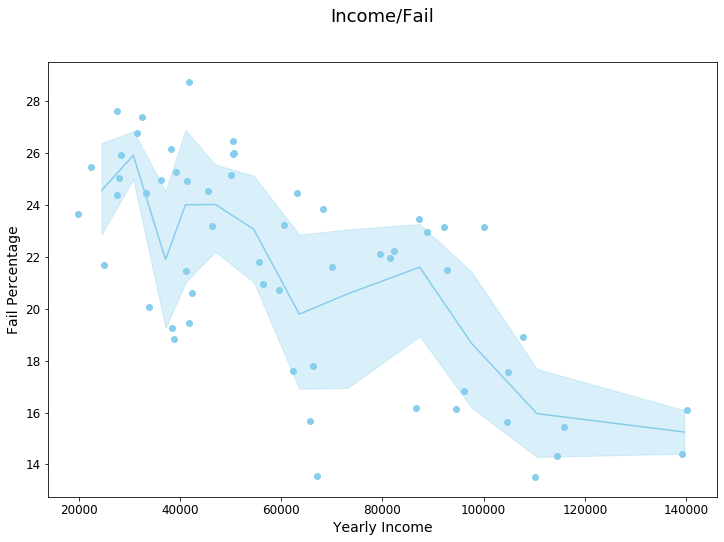

In [848]:
plot_scatter(d=econ_failure_rate_dict["all"].sort_values("Income"), title='Income/Fail', xlabel='Yearly Income', ylabel='Fail Percentage')

We can se that there is a lot of uncertenty (wide ocones), but besides this a linear relation ship is still clearly visible.

Finally, we calculate the correlation.

In [ ]:
econ_failure_rate_dict["all"].corr().iloc[0,1]

We can draw the conclusion that there is a correlation between the failure rate of establishments and economic prosperity of an neighbourhood.  
Next we will look if the city of Chicago does more frequent inspections in low income areas.

In [ ]:
#number of inspections per zip code and risk
per_risk_count = data_chicago.groupby(["Zip" ,"Risk"]).count()["Address"]
per_risk_count.head()

Zip    Risk           
60601  Risk 1 (High)      2339
       Risk 2 (Medium)     549
       Risk 3 (Low)         43
60602  Risk 1 (High)       996
       Risk 2 (Medium)     238
Name: Address, dtype: int64

In [ ]:
#getting the number of unique establishments
unique_est = data_chicago.groupby(["Zip", "DBA Name","Risk"]).count().reset_index()
#counting the number of establishments per zip code and risk
est_per_risk = unique_est.groupby(["Zip","Risk"]).count()["Address"]
est_per_risk.head(6)

Zip    Risk           
60601  Risk 1 (High)      231
       Risk 2 (Medium)     88
       Risk 3 (Low)        20
60602  Risk 1 (High)       91
       Risk 2 (Medium)     32
       Risk 3 (Low)         6
Name: Address, dtype: int64

We calculate the inspection frequency by dividing the number of inspections by the number of establishments per zip code and risk. We have to distinguish per risk as the high risk establishments get controlled more.

In [ ]:
rate_of_insp = per_risk_count/est_per_risk

In [ ]:
rate_of_insp = rate_of_insp.reset_index()

In [ ]:
rate_of_insp_dict = {}
for i in data_chicago_dict.keys():
    dach = data_chicago_dict[i]
    prc = dach.groupby(["Zip" ,"Risk"]).count()["Address"]
    ue = dach.groupby(["Zip", "DBA Name","Risk"]).count().reset_index()
    #epr = ue.groupby(["Zip","Risk"]).count()["Address"]
    epr = ue.groupby(["Zip","Risk"]).mean()["Address"]
    roi = epr#prc/epr
    roi = roi.reset_index()
    rate_of_insp_dict[i] = roi

We will use the frequency of Risk 2 establishments.

In [ ]:
rate_of_insp = rate_of_insp[rate_of_insp["Risk"]=='Risk 2 (Medium)'].set_index("Zip")
rate_of_insp.sort_index(inplace=True)

In [ ]:
econ_rate_insp = rate_of_insp.join(econ_chicago,how='inner')

In [ ]:
def econ_insp_rate_risk(risk = 'Risk 2 (Medium)', year = "all", dicti = rate_of_insp_dict):
    roi = dicti[year]
    rate_of_insp = roi[roi["Risk"]==risk].set_index("Zip")
    rate_of_insp.sort_index(inplace=True)
    return rate_of_insp.join(econ_chicago,how='inner')

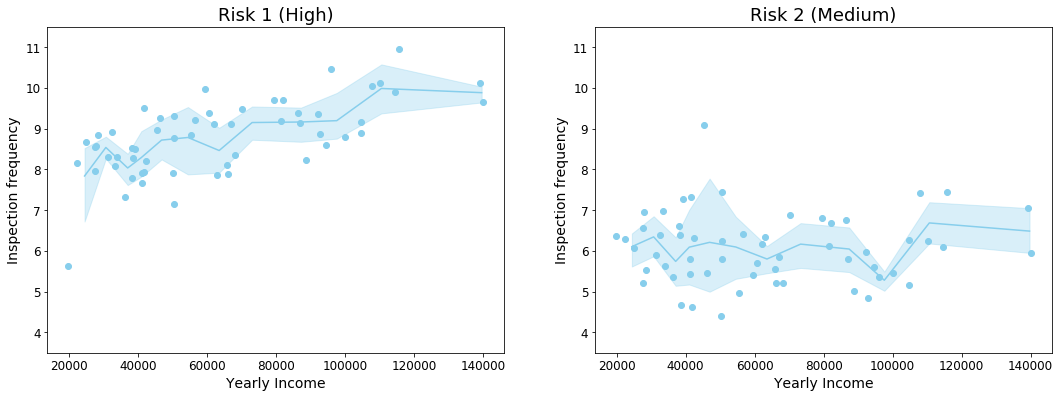

In [820]:
risks = ["Risk 1 (High)", "Risk 2 (Medium)"]
eris = []
fig = plt.figure(figsize=(18,6))
#plt.title('Income/Inspection Frequency')
for i, r in enumerate(risks):
    eris.append(econ_insp_rate_risk(r))
    ax = fig.add_subplot(1, 2, i+1)
    #ax.scatter(eris[-1]["Income"].to_list(), eris[-1]["Address"].to_list())
    ax.set_title(r, fontsize=18)
    ax.set_ylim(3.5,11.5)
    d = econ_insp_rate_risk(r)
    bdf = bootStrap(econ_insp_rate_risk(r).sort_values("Income"))
    ax.scatter(d["Income"].to_list(), d["Address"].to_list(), color='#87ceec')
    ax.plot(bdf["inc_mean"], bdf["fail_mean"], color='#87ceec')
    ax.fill_between( bdf["inc_mean"].to_list(), bdf["fail_low"].to_list(), bdf["fail_high"].to_list(), color = '#87ceec50')
    ax.set_xlabel('Yearly Income', fontsize=14)
    ax.set_ylabel('Inspection frequency',  fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    

plt.show()
fig.savefig('first_risk.png')


Shows average inspection per buisness, so positive correlation means that buisnesses in low income neighbourhoods are more likely to fail and go out of business.

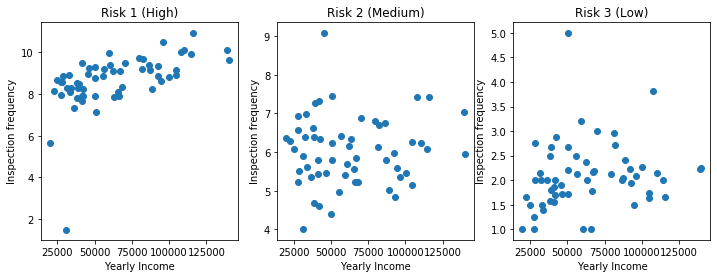

In [43]:
risks = ["Risk 1 (High)", "Risk 2 (Medium)","Risk 3 (Low)"]
eris = []
fig = plt.figure(figsize=(12,4))
#plt.title('Income/Inspection Frequency')
for i, r in enumerate(risks):
    eris.append(econ_insp_rate_risk(r))
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(eris[-1]["Income"].to_list(), eris[-1]["Address"].to_list())
    ax.set_title(r)
    ax.set_xlabel('Yearly Income')
    ax.set_ylabel('Inspection frequency')
    

plt.show()

In [ ]:
for i, r in enumerate(risks):
    print("The correlation for", r, "is:\t",eris[i].corr().iloc[0,1])

The correlation for Risk 1 (High) is:	 0.6424394780599814
The correlation for Risk 2 (Medium) is:	 0.022062994757707302


Having a look at outliers to check that we have sufficient data for each zip code.

In [823]:
outliers = eris[0].sort_values("Address", ascending = True).reset_index().head()
print(outliers)
outliers = outliers["Zip"].to_list()
print(outliers)
outliers_ch = data_chicago[data_chicago.index.isin(outliers)]
print(outliers_ch.groupby("Zip").count()["Risk"])
print(outliers_ch[outliers_ch["Risk"] == "Risk 1(high)"].groupby("Zip").count()["Risk"])
#outliers_ch[outliers_ch["Risk"] == "Risk 3 (Low)"].groupby("Zip").head(5)

     Zip           Risk   Address  Income
0  60621  Risk 1 (High)  5.627907   19845
1  60645  Risk 1 (High)  7.138298   50589
2  60651  Risk 1 (High)  7.330189   36283
3  60608  Risk 1 (High)  7.675439   41226
4  60617  Risk 1 (High)  7.784530   38417
['60621', '60645', '60651', '60608', '60617']
Zip
60608    3402
60617    2009
60621     603
60645     813
60651    1312
Name: Risk, dtype: int64
Series([], Name: Risk, dtype: int64)


An problem here is that we look at an aggregate, so in rich neighbourhoods the high risk establishments survive longer and therefore get controlled more.  
Also note that the Inspection Frequency is over the time of the entire Data set, this is not an yearly number.  
Don't have enough data for low risk, that is why we don't show it.

Next we try to improve the above analysis by looking at how many days are between inspections on average for an establishment in a zip code.

In [824]:
#To do this we need the data column
uee = (dach.groupby(["Zip", "DBA Name","Risk"])["Date"])
uee.head()

Zip
60601   2019-11-05
60601   2019-10-29
60601   2019-10-16
60601   2019-10-11
60601   2019-10-11
           ...    
60827   2014-01-13
60827   2013-12-19
60827   2013-09-09
60827   2012-11-09
60827   2012-11-09
Name: Date, Length: 68603, dtype: datetime64[ns]

In [825]:
#getting the failure data over all years
dach = data_chicago_dict["all"]
#counting the number of inspection per zip code and risk level
prc = dach.groupby(["Zip" ,"Risk"]).count()["Address"]
#counting the number of establishments per zip code and risk
ue = (dach.groupby(["Zip", "DBA Name","Risk"]).count()["Results"]).to_frame()
#calculating the difference between the fist and last inspection of an establishment.
existance = uee.max() - uee.min()

new = ue.join(existance, rsuffix = "r")
#removing the establishments that have had all inspection on the same day(that did not pass the first inspection and then never reapplied)
new = new[new["Date"] > np.timedelta64(0,"D") ]
#calculating the average inpection frequency for all establishments
newer = new["Date"]/new["Results"]
newest =  newer.reset_index("DBA Name")
n= newest.drop("DBA Name", axis=1)
#converting the timedelta to int
n[0] = pd.to_numeric(n[0].dt.days, downcast='integer')
#calculating the mean frequency for all the Zip codes.
ner= n.groupby(["Zip", "Risk"]).mean().reset_index()
dictr ={"all":ner}

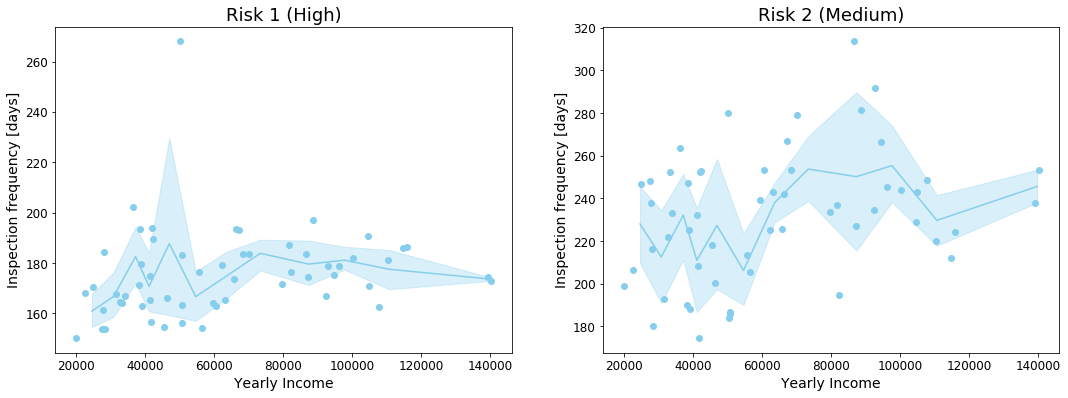

In [867]:
#Creating a plot like before but with the inspection frequency in days for the establishments
risks = ["Risk 1 (High)", "Risk 2 (Medium)"]
eris = []
fig = plt.figure(figsize=(18,6))
for i, r in enumerate(risks):
    #joining with economic data
    eris.append(econ_insp_rate_risk(r, dicti=dictr))
    ax = fig.add_subplot(1, 2, i+1)
    #ax.scatter(eris[-1]["Income"].to_list(), eris[-1]["Address"].to_list())
    ax.set_title(r, fontsize=18)
    d = eris[-1]
    d.columns = ["Risk", "Address", "Income"]
    bdf = bootStrap(d.sort_values("Income"))
    ax.scatter(d["Income"].to_list(), d["Address"].to_list(), color='#87ceec')
    ax.plot(bdf["inc_mean"], bdf["fail_mean"], color='#87ceec')
    ax.fill_between( bdf["inc_mean"].to_list(), bdf["fail_low"].to_list(), bdf["fail_high"].to_list(), color = '#87ceec50')
    ax.set_xlabel('Yearly Income', fontsize=14)
    ax.set_ylabel('Inspection frequency [days]',  fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    
plt.show()
fig.savefig('Plots/scatter_income2.png')


In [827]:
eris[0].corr()

,0,Income
0,1.000000,0.185109
Income,0.185109,1.000000


Here we see the inspection frequency in days per stablishment, there might be a lot of low risk establishments in low income areas that close down shortly after opening.

Again looking if we have sufficent data.

In [828]:
ris_econ = (data_chicago.groupby(["Zip", "Risk"]).count()["Results"]).reset_index("Risk").join(econ_chicago)
ris_econ[ris_econ["Risk"]=="Risk 2 (Medium)"].sort_values("Income").head(5)

,Risk,Results,Income
Zip,,,
60621,Risk 2 (Medium),356,19845
60624,Risk 2 (Medium),427,22467
60649,Risk 2 (Medium),377,24941
60636,Risk 2 (Medium),499,27573
60644,Risk 2 (Medium),412,27617


Note: When we did this analysis we saw we have very little data for low risk and then decided to only analyse high and medium risk.
We also noticed that 60827 has very little inspections
We also always include the airport, which has no income data.
That is why we decided to remove them in the beginning of Q1.

Next we go on to calculate the fraction of Inspections ending with Out of Business as Result.

In [829]:
dach = data_chicago_dict["all"]
out_of_b = dach.groupby(["Zip","Results"])["Risk"].count().to_frame()

In [833]:
oobb =out_of_b.reset_index()
oob = oobb.set_index(["Zip"])
#only taking the ones with Out of Business
oo = oob[oob["Results"]=="Out of Business"]["Risk"].to_frame()#.set_index("Zip")#.count()
#sum of all that didn't end in OoB
o = oob[~(oob["Results"]=="Out of Business")]["Risk"].to_frame().groupby("Zip").sum()#.count()#.groupby("Zip").reset_index(0)
#Percentage of OoB results
poob = oo/o*100

In [834]:
#Joining with economic data
poobe = poob.join(econ_chicago,how='inner')
poobe.head()

,Risk,Income
Zip,,
60601,6.003617,110215
60602,4.625736,115774
60603,5.785627,140114
60604,6.312900,114565
60605,9.154639,107811


In [836]:
bpoobe = poobe
bpoobe.columns = ["Count", "Income"]

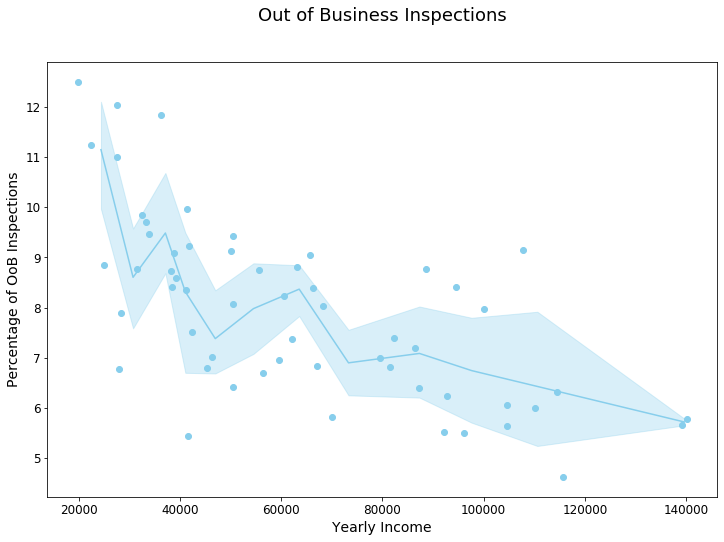

In [850]:
plot_scatter(d=bpoobe.sort_values("Income"), title='Out of Business Inspections', xlabel='Yearly Income', ylabel='Percentage of OoB Inspections')

In [868]:
#plt.savefig('Plots/scatter_oob.png')

In [851]:
poobe.corr()

,Count,Income
Count,1.000000,-0.656317
Income,-0.656317,1.000000


### In-depth: Violations
We want to see how violations are distributed between low and high income areas. We also show how our quantization in a different way shows the correlation between income and food safety.

,Low,High
Results,,
Business Not Located,0.000303,0.000281
Fail,0.207172,0.168728
No Entry,0.031880,0.030026
Not Ready,0.008261,0.010212
Out of Business,0.080607,0.062488
Pass,0.525434,0.556539
Pass w/ Conditions,0.146344,0.171726
Other,0.121050,0.103007


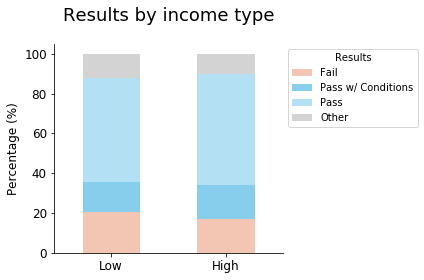

In [590]:
results_vs = pd.DataFrame()
results_vs['Low'] = data[data["Zip"].isin(incomes['low'])].groupby('Results').count()['Chain']
results_vs['High'] = data[data["Zip"].isin(incomes['high'])].groupby('Results').count()['Chain']
results_vs.loc['Other'] = results_vs.drop(['Fail', 'Pass w/ Conditions', 'Pass']).sum()
results_vs /= results_vs.loc[['Fail', 'Pass w/ Conditions', 'Pass', 'Other']].sum()
display(results_vs)
results_vs *= 100
ax = plt.gca()
plt.xlim(-0.5,1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Percentage (%)', fontsize=12)
plt.title('Results by income type', fontsize=18, y =1.08)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cmap = ListedColormap(['#F3C6B3', '#87CEEC', '#B3E0F3', '#D3D3D3'])
results_vs.loc[['Fail', 'Pass w/ Conditions', 'Pass', 'Other']].transpose().plot(kind='bar', stacked=True, ax=ax, cmap=cmap, rot=0)
ax.get_legend().set_bbox_to_anchor((1, 1))
plt.tight_layout()
plt.savefig('results_by_income.png')


In [576]:
results_percentage = pd.DataFrame(columns=['Low', 'High'])
results_percentage.loc['Pass'] = results_vs.loc['Pass']+results_vs.loc['Pass w/ Conditions']
results_percentage.loc['Fail'] = results_vs.loc['Fail']
results_percentage = results_percentage.div(results_percentage.sum(axis=0), axis=1)
results_percentage

,Low,High
Pass,0.764296,0.811896
Fail,0.235704,0.188104


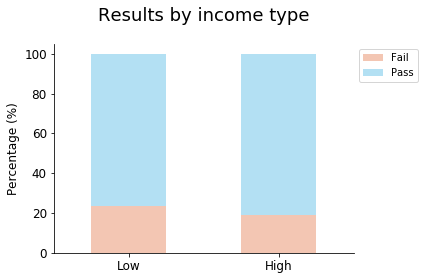

In [577]:
plt.figure(0)
ax = plt.gca()
plt.xlim(-0.5,1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Percentage (%)', fontsize=12)
plt.title('Results by income type', fontsize=18, y =1.08)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cmap = ListedColormap(['#F3C6B3', '#B3E0F3'])
(results_percentage.loc[['Fail', 'Pass']]*100).transpose().plot(kind='bar', stacked=True, ax=ax, cmap=cmap, rot=0)
ax.get_legend().set_bbox_to_anchor((1, 1))
plt.tight_layout()
plt.savefig('results_by_income_type.png')

In [593]:
violations_income ={}
critical_or_serious_violations = range(1,29+1)
for tag in ["low", "high"]:
    violations_income[tag] = violation_numbers.reset_index().rename(columns={"Violations": "Violation numbers"}).merge(data[(data["Zip"].isin(incomes[tag]))].reset_index(), on='Inspection ID', how='inner')
    violations_income[tag] = violations_income[tag][violations_income[tag]["Results"] == 'Fail']
    


In [760]:
def create_vn_percentages(violation_numbers_series):
    critical_or_serious_violations = range(1,29+1)
    violation_numbers_exploded = violation_numbers_series.explode().dropna().sort_values()
    violation_numbers_exploded = violation_numbers_exploded[list(map(lambda x: x in critical_or_serious_violations, violation_numbers_exploded.values))]
    violation_numbers_percentages = violation_numbers_exploded.groupby(violation_numbers_exploded).count()/len(violation_numbers_exploded)*100
    return violation_numbers_percentages

def plot_violation_distribution(violation_dict):
    numbers_df = pd.DataFrame()
    keys = []
    for k,v in violation_dict.items():
        tmp = create_vn_percentages(v['Violation numbers'])
        numbers_df[k] = tmp.copy()
        keys.append(k)
    vpc = (numbers_df[keys[0]][numbers_df[keys[0]] + numbers_df[keys[1]] > 4]/numbers_df[keys[1]][numbers_df[keys[0]] + numbers_df[keys[1]] > 4])
    vpc = vpc.apply(np.log).apply(np.abs)
    vpc = vpc.sort_values(ascending=False)
    numbers_df = numbers_df.loc[vpc.index[0:5]]
    ax = plt.gca()
    plt.xlim(-0.5,1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Percentage (%)', fontsize=14)
    ax.set_xlabel('Violation number', fontsize=14)
    plt.title('Distribution of Violation types', fontsize=18, y =1.08)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    cmap = ListedColormap(['#F3C6B3', '#B3E0F3'])
    numbers_df.plot.bar(figsize=(10,5), rot=0, cmap=cmap, ax=ax)


We plot the ones with the highest relative difference in representation.

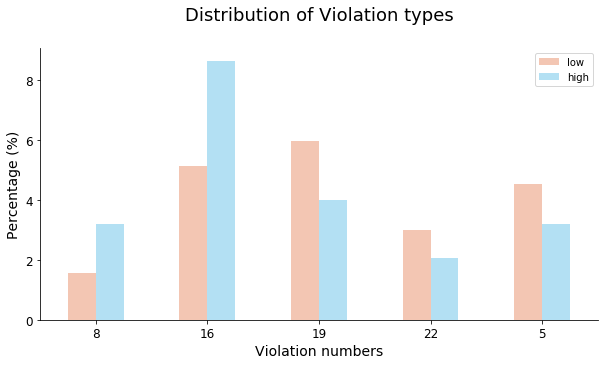

In [761]:
plot_violation_distribution(violations_income)
# should add confidence intervals here as well?
# So low income areas have problems with insects and rodents
# maybe run word frequency count on violation for all 3 to get an idea what the differences are.

In [855]:
violations_income ={}
for tag in ["low",  "high"]:
    violations_income[tag] = violation_numbers.reset_index().rename(columns={"Violations": "Violation numbers"}).merge(data[(data["Zip"].isin(incomes[tag]))&(data["Results"] == "Fail")].reset_index(), on='Inspection ID', how='inner')

In [ ]:
for tag in ["low", "high"]:
    violations_income[tag] = data[data["Zip"].isin(incomes[tag])]["Violations"]

In [399]:
from nltk.corpus import stopwords

def word_counter_for_data(dataset_dict, tags):
    sw = stopwords.words('english')
    comments = {}
    lem = {}
    word_counter = {}
    violations_income_len = {}
    for tag in tags:
        l = dataset_dict[tag].copy().apply(str).apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))#.apply(lambda xs: list(map(lambda x: int(x), xs)))

        comments[tag] = " ".join(l).lower()
        print(comments[tag][0:100])

        splt = str.split(comments[tag])

        words = [word for word in splt if not word in sw and len(word) > 2]

        from collections import Counter
        word_freq = Counter(words)
        common_words = word_freq.most_common()
        word_counter[tag] = pd.DataFrame(common_words)
        word_counter[tag].to_pickle("data/"+tag+"_nltk.pkl")
        violations_income_len[tag] = word_counter[tag].sum()[1]

        word_counter[tag]["word_freq"] = word_counter[tag][1]/violations_income_len[tag]*100
        word_counter[tag].columns = ["words", "count", "word_freq"]
    return word_counter

In [364]:
low_high  =word_counter["low"].merge(word_counter["high"], on='words', how='inner')
low_high[low_high["word_freq_x"]>low_high["word_freq_y"]*1.5].head(30)
low_high["ratio"] = low_high["word_freq_x"]/low_high["word_freq_y"]
display(low_high.sort_values("ratio", ascending=False)[low_high["count_y"]>100].head(20))
display(low_high.sort_values("ratio")[low_high["count_x"]>100].head(20))

/home/widmark/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,words,count_x,word_freq_x,count_y,word_freq_y,ratio
295,mice,2640,0.058400,163,0.004026,14.506466
170,droppings,5614,0.124189,943,0.023290,5.332195
580,exteriors,822,0.018184,144,0.003557,5.112751
429,interiors,1443,0.031921,255,0.006298,5.068407
573,scattered,859,0.019002,164,0.004051,4.691315
700,carts,539,0.011923,104,0.002569,4.641953
672,bottoms,596,0.013184,121,0.002988,4.411702
583,furnace,799,0.017675,179,0.004421,3.997966
327,thru,2177,0.048158,520,0.012843,3.749733
262,bases,3034,0.067116,823,0.020327,3.301878


/home/widmark/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,words,count_x,word_freq_x,count_y,word_freq_y,ratio
1208,sushi,154,0.003407,1178,0.029095,0.117090
1381,dishroom,112,0.002478,826,0.020401,0.121446
1311,slight,130,0.002876,870,0.021487,0.133835
998,informed,239,0.005287,1574,0.038875,0.136000
1219,onsite,149,0.003296,943,0.023290,0.141521
1120,maker,188,0.004159,940,0.023216,0.179133
1435,form,101,0.002234,433,0.010694,0.208919
1197,dishwash,159,0.003517,671,0.016573,0.212236
1013,beer,234,0.005176,957,0.023636,0.219003
1223,signage,148,0.003274,604,0.014918,0.219467


In [365]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(212, 200%%, %d%%)" % (1/font_size*200+50)


In [366]:
from wordcloud import WordCloud
from PIL import Image
def make_word_cloud(words_freq_dict): 
    oval = np.array(Image.open('data/oval'))
    wc = WordCloud(scale=3,background_color='white', mask=oval)
    plt.figure(0,figsize=(17,17))
    plt.imshow(wc.generate_from_frequencies(words_freq_dict).recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")
    plt.axis("off")

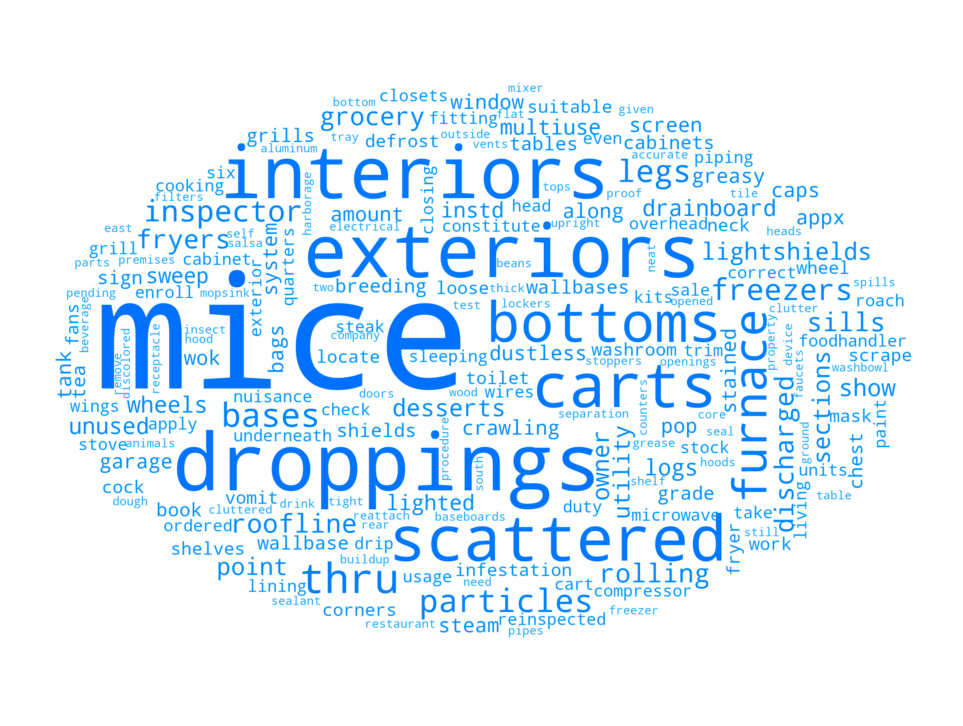

In [367]:
low_inc_freq = low_high[low_high["count_y"]>100][['words','ratio']].set_index('words')
low_inc_freq['ratio'] = low_inc_freq['ratio'].map(lambda x: x**4)
low_inc_freq = low_inc_freq.to_dict()['ratio']
make_word_cloud(low_inc_freq)

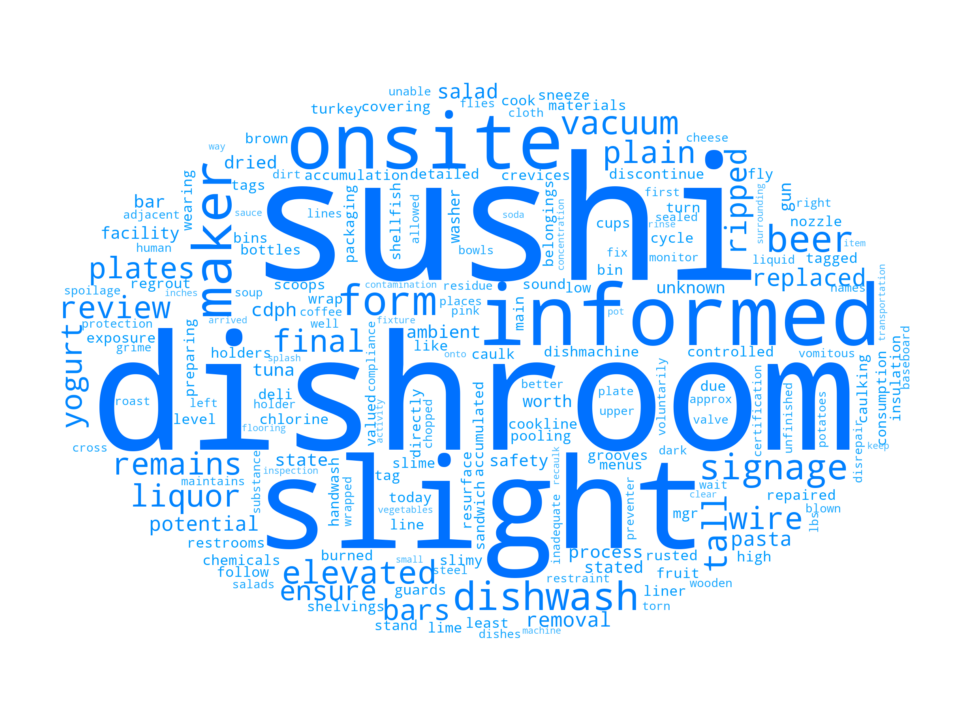

In [368]:
high_inc_freq = low_high[low_high["count_x"]>100][['words','ratio']].set_index('words')
high_inc_freq['ratio'] = high_inc_freq['ratio'].map(lambda x: 1/x**4)
high_inc_freq = high_inc_freq.to_dict()['ratio']
make_word_cloud(high_inc_freq)

# Research Q2: Restaurant chains vs small businesses

## Results

In [369]:
data_chains = data[data['Chain'] != 'invalid']
data_small_business = data[data['Chain'] == 'invalid']

We group the datasets by inspection results, count them, and dividing them by their length to see what the distribution of the results are.  

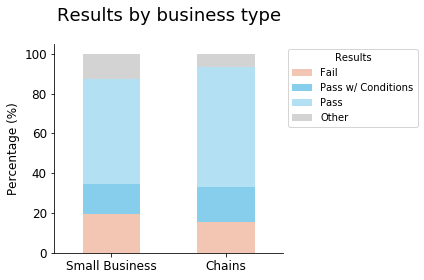

In [507]:
dsb_size = len(data_small_business)
dc_size = len(data_chains)
results_vs = pd.DataFrame()
results_vs['Small Business'] = data_small_business.groupby('Results').count()['DBA Name'].apply(lambda x: x/dsb_size)
results_vs['Chains'] = data_chains.groupby('Results').count()['DBA Name'].apply(lambda x: x/dc_size)
results_vs.loc['Other'] = results_vs.drop(['Fail', 'Pass w/ Conditions', 'Pass']).sum()
results_vs *= 100
ax = plt.gca()
plt.xlim(-0.5,1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Percentage (%)', fontsize=12)
plt.title('Results by business type', fontsize=18, y =1.08)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cmap = ListedColormap(['#F3C6B3', '#87CEEC', '#B3E0F3', '#D3D3D3'])
results_vs.loc[['Fail', 'Pass w/ Conditions', 'Pass', 'Other']].transpose().plot(kind='bar', stacked=True, ax=ax, cmap=cmap, rot=0)
ax.get_legend().set_bbox_to_anchor((1, 1))
plt.tight_layout()
plt.savefig('results_by_business_type.png')
#fig, ax_list = plt.subplots(4,3, figsize=(30,20))
#
# for i, year in enumerate(data['Year'].sort_values().unique()):
#     ax = ax_list[int(i/3)][i%3]
#     ax.set_xlim(0,1)
#     results_vs = pd.DataFrame()
#     dsb_size = len(data_small_business[data_small_business['Year'] == year])
#     dc_size = len(data_chains[data_chains['Year'] == year])
#     results_vs['Small Business'] = data_small_business[data_small_business['Year'] == year].groupby('Results').count()['DBA Name'].apply(lambda x: x/dsb_size)
#     results_vs['Chains'] = data_chains[data_chains['Year'] == year].groupby('Results').count()['DBA Name'].apply(lambda x: x/dc_size)
#     results_vs.plot.barh(title=year, ax=ax)

As we can see, chains generally pass inspections more often than small businesses, and fail less often.

We quantize a bit by setting "Pass" as both "Pass" and "Pass w/ Conditions", and "Fail" as "Fail". The other rows are not connected to the safety of the establishment, so we ignore those for now.

In [508]:
results_percentage = pd.DataFrame(columns=['Small Business', 'Chains'])
results_percentage.loc['Pass'] = results_vs.loc['Pass']+results_vs.loc['Pass w/ Conditions']
results_percentage.loc['Fail'] = results_vs.loc['Fail']
results_percentage = results_percentage.div(results_percentage.sum(axis=0), axis=1)
results_percentage

,Small Business,Chains
Pass,0.779341,0.831602
Fail,0.220659,0.168398


In [372]:
# Assuming a binomial distribution (z-val = 1.96)
conf_interval_chains = 1.96*np.sqrt(results_percentage.loc['Pass']['Chains']*(1-results_percentage.loc['Pass']['Chains'])/len(data_chains))
conf_interval_sb = 1.96*np.sqrt(results_percentage.loc['Pass']['Small Business']*(1-results_percentage.loc['Pass']['Small Business'])/len(data_small_business))

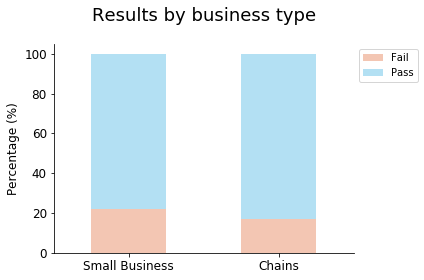

In [487]:
plt.figure(0)
ax = plt.gca()
plt.xlim(-0.5,1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Percentage (%)', fontsize=12)
plt.title('Results by business type', fontsize=18, y =1.08)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cmap = ListedColormap(['#F3C6B3', '#B3E0F3'])
(results_percentage.loc[['Fail', 'Pass']]*100).transpose().plot(kind='bar', stacked=True, ax=ax, cmap=cmap, rot=0)
ax.get_legend().set_bbox_to_anchor((1, 1))
plt.tight_layout()
plt.savefig('results_by_business_type2.png')

We choose the failure rate as the safety measurement, as a customer going to a restaurant that would potentially fail an inspection would be unsafe.

In [375]:
dsb = data_small_business.groupby('Results').count().rename(columns={"DBA Name": "CountSB"})["CountSB"]
dc = data_chains.groupby('Results').count().rename(columns={"DBA Name": "CountChains"})["CountChains"]
results_chains_sb = pd.DataFrame(dsb).join(dc)
results_chains_sb.loc['Pass'] += results_chains_sb.loc['Pass w/ Conditions']
results_chains_sb = results_chains_sb.loc[['Fail','Pass']]
fisher_exact(results_chains_sb) 

(1.3982108840467766, 2.1479022292497926e-58)

The probability of observing a distribution as or even more imbalanced than the one we have by chance is p=7.6e-59. Any reasonable significance level would indicate that our findings are statistically significant.

# Q1 and Q2: How are they connected?

We create a series that contains the percentage of chains compared to the overall number of restaurants per zip code.

In [514]:
chains_per_zip = data_chains.groupby('Zip').count().rename(columns={"DBA Name": "Count"})["Count"]
sb_per_zip = data_small_business.groupby('Zip').count().rename(columns={"DBA Name": "Count"})["Count"]
chains_per_zip /= chains_per_zip+sb_per_zip

We do the same analysis as in Q1, by using scatterplots and correlation.
We plot the dataset in the same way as we did in Q1; we create a scatter plot with income and the number of chains per small business.

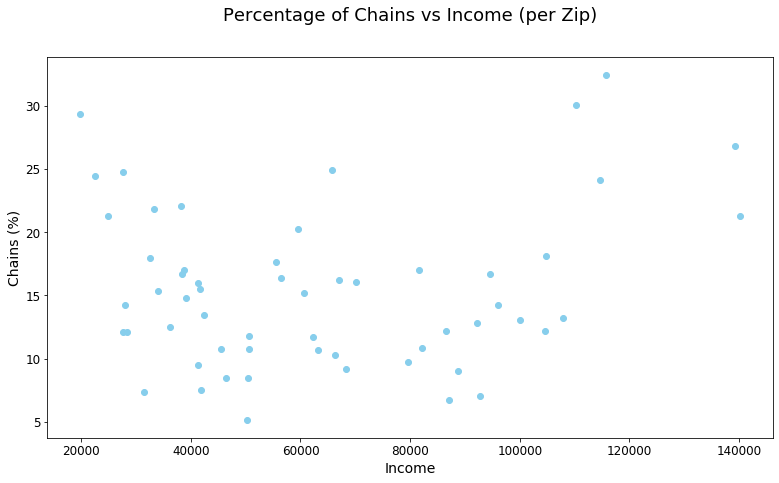

<Figure size 432x288 with 0 Axes>

In [574]:
chains_per_zip.index = chains_per_zip.index.map(lambda x: str(int(x)))
income_vs_chains = econ_failure_rate.drop('Count', axis=1).join(chains_per_zip, how='inner')
cmap = ListedColormap(['#B3E0F3'])
plt.figure(0, figsize=(13,7))
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.set_ylabel('Chains (%)', fontsize=14)
ax.set_xlabel('Income', fontsize=14)
plt.title('Percentage of Chains vs Income (per Zip)', fontsize=18, y =1.08)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.scatter(income_vs_chains['Income'].to_list(), (income_vs_chains['Count']*100).to_list(), color='#87CEEC')
plt.savefig('chains_vs_income.png')
plt.show()
plt.tight_layout()

In [544]:
income_vs_chains.corr().loc['Income', 'Count']

0.14892761090509898

We see a very weak positive correlation between income and number of chains in an area.

To go more in-depth we will now look at what critical violations that are made by the respective groups.

In [376]:
data_small_business = violation_numbers.reset_index().rename(columns={"Violations": "Violation numbers"}).merge(data_small_business, on='Inspection ID', how='inner')
data_chains = violation_numbers.reset_index().rename(columns={"Violations": "Violation numbers"}).merge(data_chains, on='Inspection ID', how='inner')

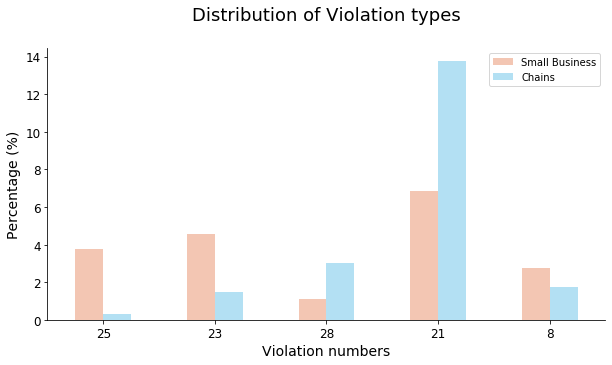

In [763]:
plot_violation_distribution({'Small Business': data_small_business, 'Chains': data_chains})

We see that the different groups are prone to making the same violations. However, violation 21 is clearly overrepresented in chains compared to small businesses, which corresponds to a lack of food service manager when handling hazardous foods, such as deli meats and sandwiches. Small businesses are highly overrepresented in violation 25, which corresponds to toxic items not stored properly, and 23, which concerns date labeling refrigerated food. The most numerous violation, number 3, corresponds to a failure in "MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING", which mainly seems to concern the lack of a written employee health policy.

In [ ]:
data_chains[data_chains['Violation numbers'].map(lambda x: 21 in x)]['Violations'].iloc[90]

In [431]:
data_chains_sb_dict = {}
data_chains_sb_dict['chains'] = data_chains[data_chains['Results'] == 'Fail']['Violations']
data_chains_sb_dict['sb'] = data_small_business[data_small_business['Results'] == 'Fail']['Violations']

We see that there is no overlap in the violations except for violation 8, so we assume that the word clouds show different words.

In [ ]:
word_count = word_counter_for_data(data_chains_sb_dict, ['chains', 'sb'])

In [433]:
chains_vs_sb_violations = word_count["chains"].merge(word_count["sb"], on='words', how='inner')
chains_vs_sb_violations["ratio"] = chains_vs_sb_violations["word_freq_x"]/chains_vs_sb_violations["word_freq_y"]
display(chains_vs_sb_violations.sort_values("ratio", ascending=False)[chains_vs_sb_violations["count_y"]>100].head(20))
display(chains_vs_sb_violations.sort_values("ratio")[chains_vs_sb_violations["count_x"]>100].head(20))
word_count["chains"][word_count["chains"]["words"] == 'meatballs']

/home/widmark/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,words,count_x,word_freq_x,count_y,word_freq_y,ratio
533,sandwich,108,0.023084,178,0.003833,6.022126
680,fountain,66,0.014107,122,0.002627,5.369455
601,nozzles,84,0.017954,176,0.003790,4.737102
614,tuna,81,0.017313,171,0.003683,4.701485
436,dumpsters,160,0.034199,382,0.008226,4.157217
828,roast,43,0.009191,108,0.002326,3.951762
856,grouting,40,0.008550,102,0.002197,3.892297
744,soft,56,0.011970,143,0.003080,3.886853
316,beverage,251,0.053650,647,0.013933,3.850486
611,syrup,82,0.017527,215,0.004630,3.785485


/home/widmark/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,words,count_x,word_freq_x,count_y,word_freq_y,ratio
483,advisory,131,0.028000,5261,0.113296,0.247143
313,bar,254,0.054291,9796,0.210958,0.257354
527,label,111,0.023726,3917,0.084353,0.281265
464,hood,141,0.030138,4927,0.106104,0.284042
324,labeled,242,0.051726,7415,0.159683,0.323929
431,cooked,162,0.034626,4948,0.106556,0.324961
197,kitchen,466,0.099605,13663,0.294234,0.338521
173,basement,541,0.115635,15464,0.333019,0.347233
418,paint,166,0.035481,4443,0.095681,0.370833
505,closing,123,0.026290,3189,0.068675,0.382822


,words,count,word_freq
867,meatballs,39,0.008336


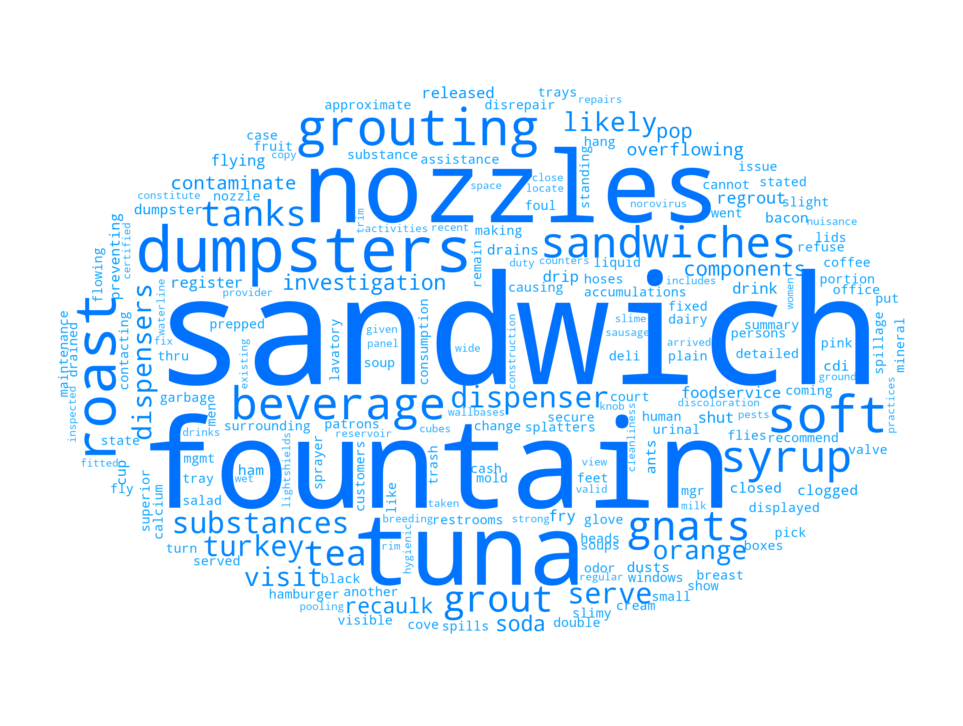

In [434]:
chains_violations_freq = chains_vs_sb_violations[chains_vs_sb_violations["count_y"]>100][['words','ratio']].set_index('words')
chains_violations_freq['ratio'] = chains_violations_freq['ratio'].map(lambda x: x**4)
chains_violations_freq = chains_violations_freq.to_dict()['ratio']
make_word_cloud(chains_violations_freq)

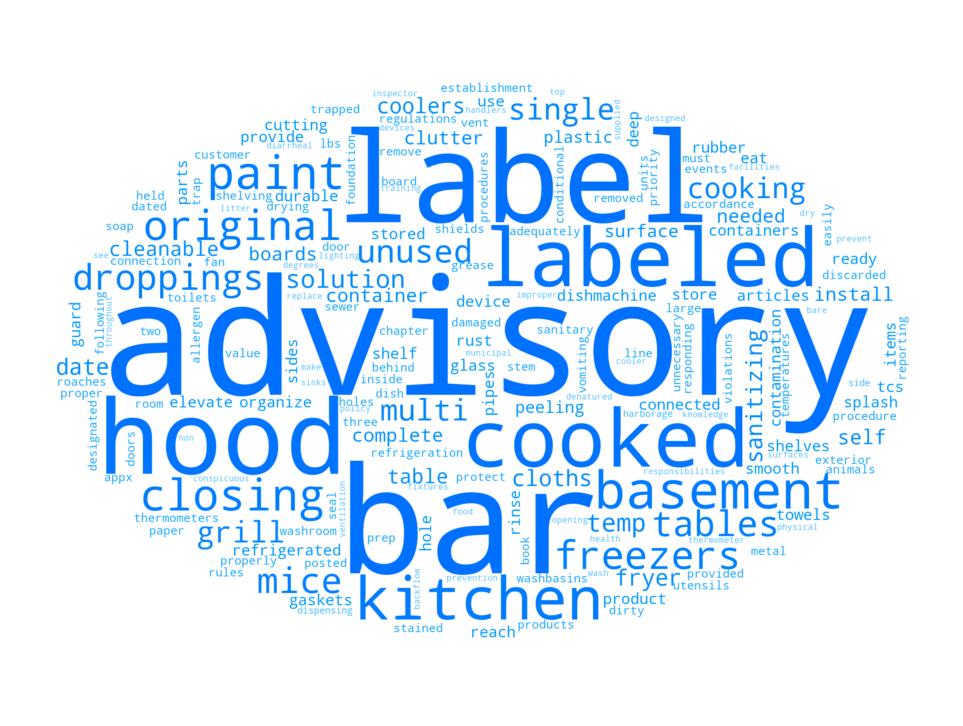

In [435]:
sb_violations_freq = chains_vs_sb_violations[chains_vs_sb_violations["count_x"]>100][['words','ratio']].set_index('words')
sb_violations_freq['ratio'] = sb_violations_freq['ratio'].map(lambda x: 1/x**4)
sb_violations_freq = sb_violations_freq.to_dict()['ratio']
make_word_cloud(sb_violations_freq)

As assumed, you can't really see any similarities to Q1.

## Conclusions

In Milestone 2, we have achieved the following objectives:

- We have shown that we can handle the dataset without the need of Spark, making collaboration between teammates and easier task.
- We have a very fine-grained analysis of each of the feature, dealing with duplicates, finding missing values and filling them accordingly so as to have a coherent corpus.
- We have understood how our data is formatted, and have transformed such features into information fit to our research objectives.
- We have connected our corpus with external data, such as map, income and restaurant chain information. This will allow us to approach more complex questions and gain more interesting insights.
- We have updated our research plan based on the analysis made.
- We have demonstrated that our main research questions are affordable given our current information, and that we can extract valuable outcomes in order to build a nice data story that raises social awareness.
- We have defined our future steps to complete the project successfully.


In Milestone 3, we have achieved the following objectives:
* We have not solved the restaurant chain identification system, but instead realized that the severity of the problem was very small.
* We decided against yearly results, since for many of the zip codes there wasn't enough of data.
* We connected the results of Q1 and Q2, and saw that the differences in Q2 couldn't be explained by the results of Q1, and that there are other things at play.
* We analyzed the violations column to get a more in-depth analysis. We analyzed the violation numbers and also had a deeper look into the comments by doing word clouds.
* We went with the data story.

There is only the poster session left:
* We will make a short conclusion out of our results, and then choose which plots and maps to use for the poster.